# Reproducing figures for the paper

In [102]:
import os
notebook_path = os.getcwd()
import numpy as np
import sys
sys.path.append('/mydata/watres/quentin/code/TRANSPORT/')
from BERT4Transit import *
from BERT4Transit.visualization import *
import pandas as pd
root_data = '/mydata/watres/quentin/code/TRANSPORT/data/'

In [101]:
tau = 1.1
f = 0.06  #2**(-(1+1.7*tau))#(2**(-(1+tau))+2**(-(1+2*tau)))/2
xi = -2/(tau*np.log(2)*np.exp(f)+np.log(1-np.exp(-2*f)))

(4 * tau / (tau-1) ) * tau * xi*np.log(1+np.exp(-f))

46.88589987243146

In [62]:
f=0.007


-8/3  * np.log(1+np.exp(-f))/np.log(1-np.exp(-2*f))

0.430123693466993

/tmp/ipykernel_49942/33914119.py:6: RuntimeWarning: divide by zero encountered in log
  xi = -2/(2*np.log(2)*np.exp(f)+np.log(1-np.exp(-2*f)))


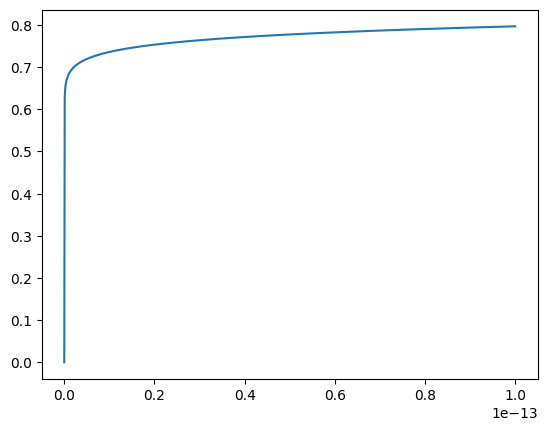

In [60]:
ls = np.linspace(0.00000000000000001,0.0000000000001, 1000)

def func(f):
    #return np.log(1-np.exp(-2*f))/(np.log(1-np.exp(-2*f)) + 2* np.log(1+np.exp(-f)) + np.exp(f) * np.log(2))
    #return (-8/3  * np.log(1+np.exp(-f))/np.log(1-np.exp(-2*f)))
    xi = -2/(2*np.log(2)*np.exp(f)+np.log(1-np.exp(-2*f)))

    return 16 * np.exp(f) *xi*np.log(1+np.exp(-f))*np.exp(-f)
plt.plot(ls, func(ls))

In [103]:
sites = ['Basel_small_storage','Basel_large_storage','Pully_small_storage','Pully_large_storage','Lugano_small_storage','Lugano_large_storage']
#sites = ['Pully_small_storage','Pully_large_storage']
algos = ['SumSquares_noBERT2_bayesian3', 'AgeDomain', 'Weibull']

algo2name = {'SumSquares_noBERT2_bayesian3': 'WATRES', 'AgeDomain': 'J-Weighted', 'Weibull':'Weibull','EHS':'EHS'} #  'MESAS':'MESAS',
sitenames = ['Site A-small', 'Site A-large', 'Site B-small', 'Site B-large', 'Site C-small', 'Site C-large']
site2name = {site: sitenames[i] for i, site in enumerate(sites)}
settings = []
for site in sites:
    pathsite = f'{notebook_path}/data/{site}/'
    for algo in algos:
        settings.append({'site':site, 
                        'pathsite': f'{notebook_path}/data/{site}/',
                        'algo': algo,
                        'path_model': os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site}_no_c_{algo}.pth.tar'),
                        'path_results': os.path.join(pathsite, 'save', f'results_BERT4TRANSIT_{site}_no_c_{algo}.pkl')
                        })
results = gather_results_all_sites(settings)

In [186]:
i = 0
site = settings[i]['site']
pathsite = settings[i]['pathsite']
model = BERT4Transit(pathsite=settings[i]['pathsite'], site=settings[i]['site'], algo=settings[i]['algo'], path_model=settings[i]['path_model'])
model.load_model(settings[i]['path_model'])
Tmax = model.Tmax

J, Q, ET, CJ, Cout = model.get_data(pathsite, site, include_concentration=True)
BATCH_SIZE = 100
n_test = 265*24
lst_test, BATCH_SIZE = model.get_time_points(pathsite, site, BATCH_SIZE, n_start=-n_test, n_end=-1)
data_test, timeyear_test = model.get_data_noBERT(pathsite, site, lst_test, BATCH_SIZE=BATCH_SIZE)
input_size = data_test.shape[1]
        
model = lightning_interface.LightningSumSquares_noBERT2_bayesian3(input_size, Tmax=Tmax)

with torch.no_grad():            
    Cout_test = torch.zeros(len(lst_test))
    CJ_test = torch.zeros((len(lst_test), Tmax))
    J_test = torch.zeros((len(lst_test), Tmax))
    Q_test = torch.zeros(len(lst_test))
    ET_test = torch.zeros(len(lst_test))
    Qinv_test = torch.zeros((len(lst_test),Tmax))
    ETinv_test = torch.zeros((len(lst_test),Tmax))

    for i,t in enumerate(lst_test):
        Cout_test[i] = Cout[t]
        CJ_test[i,:] = CJ[t-Tmax:t]
        J_test[i,:] = J[t-Tmax:t]
        Q_test[i]  = torch.sum(Q[t-Tmax:t])
        ET_test[i] = torch.sum(ET[t-Tmax:t])
        ETinv_test[i,:] = torch.flip(ET[t-Tmax:t], [0])
        Qinv_test[i,:] = torch.flip(Q[t-Tmax:t], [0])

    Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
    w = model.model.forward_w(data_test)
    w = w.detach().numpy()
    frac_year = timeyear_test
    frac_year = [el-int(el) for el in frac_year]
    frac_year = np.array([min([1-el, el]) for el in frac_year])
    winter_idxs = np.where(frac_year<=(2*30/365))[0]
    summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
    w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
    w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)

In [104]:
from scipy.interpolate import interp1d

# getting dates at the hour resolution used to test
hours_test = np.array([fractional_year_to_datetime(el) for el in np.array(results[sites[0]][algos[0]]['timeyear_test'])])

## Getting results from EHS
res_EHS = {}
for site in sites:
    res_EHS[site] = {}
    EHS_global = pd.read_csv(os.path.join(root_data, site, 'save', 'EHS_global.txt'), sep=' ')
    res_EHS[site]['TTD_lag'] = EHS_global['TTD_lag'].to_numpy().reshape(-1) * (24*7)
    res_EHS[site]['globalPQ'] = np.cumsum(EHS_global['TTD.TTD'].to_numpy().reshape(-1))
    x_vals = EHS_global['TTD_lag'].to_numpy().reshape(-1)
    y_vals = res_EHS[site]['globalPQ']
    f = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
    res_EHS[site]['ywfhat'] = (np.array([f(i*4) for i in range(1,11)])).reshape(1,-1)
    for k in range(4):
        EHS_quantile = pd.read_csv(os.path.join(root_data, sites[0], 'save', 'EHS_quantile{0}.txt'.format(k)), sep=' ') 
        res_EHS[site]['quantile{0}_PQ'.format(k)] = np.cumsum(EHS_quantile['QquantileTTD.TTD'].to_numpy().reshape(-1))
        y_vals = res_EHS[site]['quantile{0}_PQ'.format(k)]
        f = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
        res_EHS[site]['quantile{0}_ywfhat'.format(k)] = (np.array([f(i*4) for i in range(1,11)]))

if False:
    ## Getting results from MESAS
    res_MESAS = {}
    for site in sites:
        res_MESAS[site] = {}
        daily_data = pd.read_csv(os.path.join(root_data, site, 'data', f'{site}_daily.txt'))
        ndata = daily_data.shape[0]
        daily_data['datetime'] = pd.to_datetime(daily_data['datetime'], format='%Y-%m-%d')
        daily_data.set_index('datetime', inplace=True)
        target_indexes = np.array([pd.Timestamp(hour.date()) for hour in hours_test])
        idxs_test = np.array([daily_data.index.get_loc(target_index) for target_index in target_indexes])
        daily_data = daily_data.iloc[idxs_test]
        pQttd = np.load(os.path.join(root_data, site, 'save', 'pQ_mesas.npy'))
        pQttd = pQttd[:,:,0].T
        pQ = np.cumsum(pQttd, axis=1)    
        idxs_test = np.array([pQ.shape[0]+(i-ndata) for i in idxs_test])
    
        # Reproduced hydrograph
        df = pd.read_csv(os.path.join(root_data, site, 'data', f'{site}_daily.txt'))
        df = df.iloc[-365*10:]
        Cp = np.nan_to_num(df['Cp'].to_numpy())
        Cq = df['Cq'].to_numpy()[idxs_test]
        Cqhat = np.zeros(len(idxs_test))
        m = pQ.shape[1]
        for i, t in enumerate(idxs_test):
            Cqhat[i] = np.sum( np.flip(Cp[(t-m+1):(t+1)])*pQttd[t,:])
            
        res_MESAS[site]['ERROR_Cout'] = np.linalg.norm(Cqhat-Cq)/len(Cqhat)
        
        pQ = pQ[idxs_test,:]
        res_MESAS[site]['TTD_lag'] = np.arange(pQ.shape[1])*24
        res_MESAS[site]['globalPQ'] = np.mean(pQ, axis=0)
        res_MESAS[site]['ywfhat'] =  (pQ[:,[i*30 for i in range(1,11)]])
        for k in range(4):
            idxs_quantile = np.where(daily_data['Q_quantile_{0}'.format(k)])[0]
            res_MESAS[site]['quantile{0}_PQ'.format(k)] = np.mean(pQ[idxs_quantile,:], axis=0)
            res_MESAS[site]['quantile{0}_ywfhat'.format(k)] = ((res_MESAS[site]['quantile{0}_PQ'.format(k)])[[i*30 for i in range(1,11)]])

In [116]:
pQttd.shape, pQ.shape, 365*5

((3650, 2000), (3648, 2000), 1825)

In [17]:
for site in sites:
    results[site]['EHS'] = res_EHS[site]
    #results[site]['MESAS'] = res_MESAS[site]

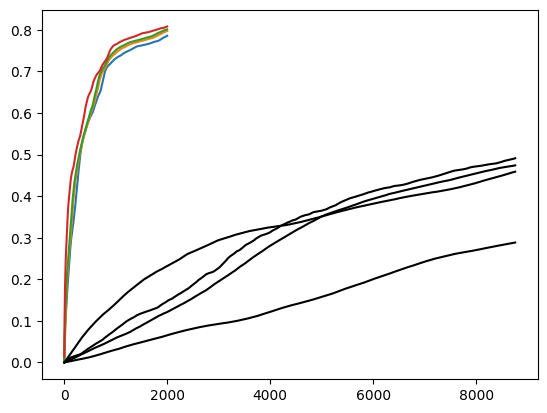

In [118]:
for k in range(4):
    #plt.plot(results[sites[0]]['EHS']['TTD_lag'], results[sites[0]]['EHS']['quantile{0}_PQ'.format(k)])
    plt.plot(results[sites[0]]['MESAS']['quantile{0}_PQ'.format(k)][:])
    plt.plot(results[sites[0]]['Weibull']['quantile{0}_PQhat'.format(k)][:24*365], color='black')

# 1. Young water fraction

In [105]:
def show_ywf(results, algo2name=None, site2name=None):
    size_marker = 100
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    markers = ['*','+', 'x',  'd','.','|']
    colors = ['red', 'orange', 'blue',  'green', 'brown', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    tickslabel = []
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        count_algo = 0
        for algo, value in res_site.items():
            mean_ywf = np.mean(res_site[algo]['ywfhat'][:, 2])
            if count_fig==1:
                plt.scatter([count_fig], mean_ywf, label=algo2name[algo], marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
            else:
                plt.scatter([count_fig], mean_ywf, marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
            count_algo += 1
            if count_algo==1:
                mean_ywf_true = np.mean(res_site[algo]['ywf_true'][:,2])
                if count_fig==1:
                    plt.scatter([count_fig], mean_ywf_true, label='Ground truth', marker='_', c='black', s=size_marker)
                else:
                    plt.scatter([count_fig], mean_ywf_true, marker='_', c='black', s=size_marker)

        tickslabel.append(site2name[site])
        

    plt.xticks(list(range(1,count_fig+1)), tickslabel, rotation = 90, fontsize=13)
    plt.legend(
        fontsize=12,
        loc='center',         # Position legend to the left center
        bbox_to_anchor=(0.5, 1.12),   # Move it outside the plot, centered vertically
        ncol=2                     # Set the number of columns
    )

    plt.ylabel('Young water fraction', fontsize=14)
    plt.savefig('comparison_ywf.png', dpi=250, bbox_inches="tight")
    plt.show()

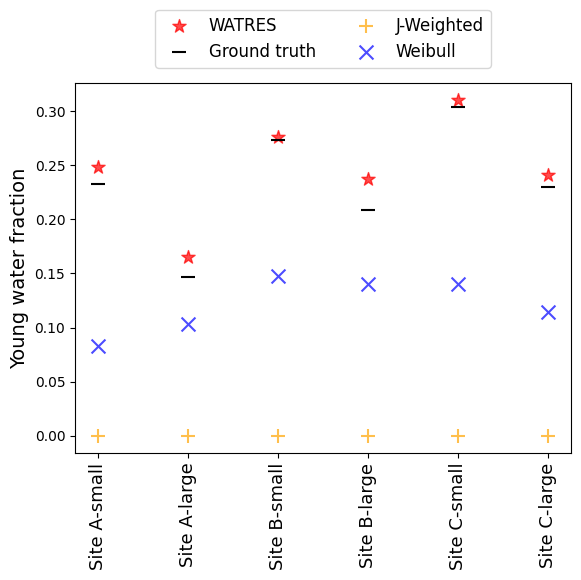

In [106]:
show_ywf(results, algo2name=algo2name, site2name = site2name)

In [179]:
def show_ywf(results, algo2name=None, site2name=None):
    size_marker = 100
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    markers = ['*','+', 'x',  'd','.','|']
    colors = ['red', 'orange', 'blue',  'green','brown', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    tickslabel = []
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        count_algo = 0
        for algo, value in res_site.items():
            if count_algo==0:
                mean_ywf_true = np.mean(res_site[algo]['ywf_true'][:,2])
            mean_ywf = np.mean(res_site[algo]['ywfhat'][:, 2])
            if count_fig==1:
                plt.scatter([count_fig], np.abs(mean_ywf_true-mean_ywf), label=algo2name[algo], marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
            else:
                plt.scatter([count_fig], np.abs(mean_ywf_true-mean_ywf), marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
            count_algo += 1
        tickslabel.append(site2name[site])
        

    plt.xticks(list(range(1,count_fig+1)), tickslabel, rotation = 90, fontsize=13)
    plt.legend(
        fontsize=12,
        loc='center',         # Position legend to the left center
        bbox_to_anchor=(0.5, 1.07),   # Move it outside the plot, centered vertically
        ncol=3                     # Set the number of columns
    )

    plt.ylabel('Absolute error on the\naverage young water fraction', fontsize=14)
    plt.savefig('comparison_ywf.png', dpi=250, bbox_inches="tight")
    plt.show()

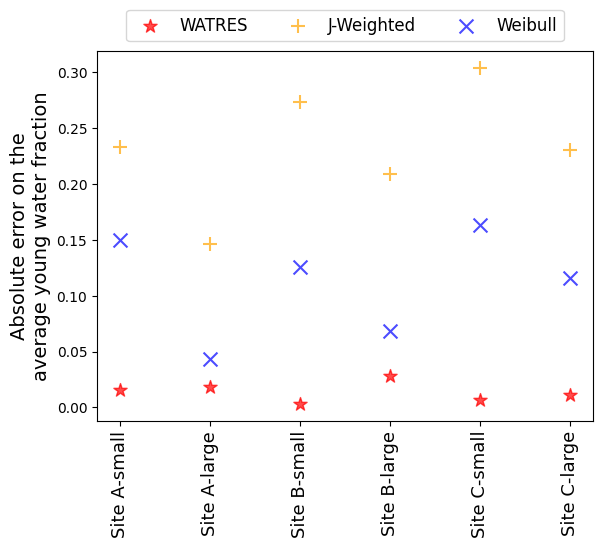

In [180]:
show_ywf(results, algo2name=algo2name, site2name = site2name)

In [164]:
def show_TS_ywf(results, algo2name=None, site2name=None):
    size_marker = 20
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    markers = ['*','+', 'x', '.', 'd','|']
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        plt.figure(count_fig)
        count_algo = 0
        for algo, value in res_site.items():
            ywf = res_site[algo]['ywfhat'][:, 2]
            if not(algo in ['EHS','Weibull','AgeDomain']):
                if count_algo==0:
                    algo1 = algo
                    ywf_true = res_site[algo]['ywf_true'][:,2]
                    plt.plot([],[], label='Ground truth',  c='black')
                    plt.plot(results[site][algo1]['timeyear_test'], ywf_true, c='black')
                plt.plot([],[], c=color[algo], alpha=0.7)
                plt.plot(results[site][algo1]['timeyear_test'], ywf, label=algo2name[algo], linestyle='dashed', c=color[algo], alpha=0.7)
                count_algo += 1
                    

        legend = plt.legend(
            title=site2name[site]+' storage',
            fontsize=11,
            loc='center',         # Position legend to the left center
            bbox_to_anchor=(0.5, 0.92),   # Move it outside the plot, centered vertically
            ncol=2                     # Set the number of columns
        )
        legend.get_title().set_fontsize('12') #legend 'Title' fontsize

        #plt.title(site2name[site], fontsize=14)

        # y limits
        site_letter = site2name[site][:7]
        bottom = float('inf')
        top = -float('inf')
        for size in ['small','large']:
            site_name_ylim = site_letter+size
            site_ylim = [site_temp for site_temp, site_temp_name in site2name.items() if (site_temp_name==site_name_ylim)][0]  
            print(site_ylim)
            bottom = np.min([bottom,np.min(np.array(results[site_ylim][algo]['ywfhat']))])
            bottom = np.min([bottom,np.min(np.array(results[site_ylim][algo]['ywf_true']))])
            top = np.max([top,np.max(np.array(results[site_ylim][algo]['ywfhat']))])
            top = np.max([top,np.max(np.array(results[site_ylim][algo]['ywf_true']))])
        plt.ylim(bottom, top)
    
        plt.ylabel('Young water fraction', fontsize=14)
        plt.xlabel('Date', fontsize=14)
        plt.savefig('comparison_ywf_{0}.png'.format(site2name[site]), dpi=250, bbox_inches="tight")
        plt.show()

Basel_small_storage
Basel_large_storage


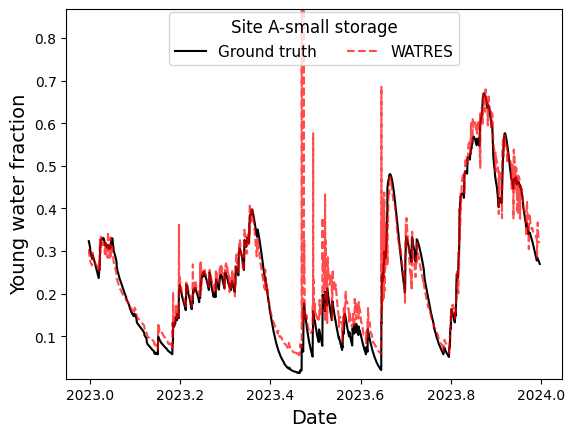

Basel_small_storage
Basel_large_storage


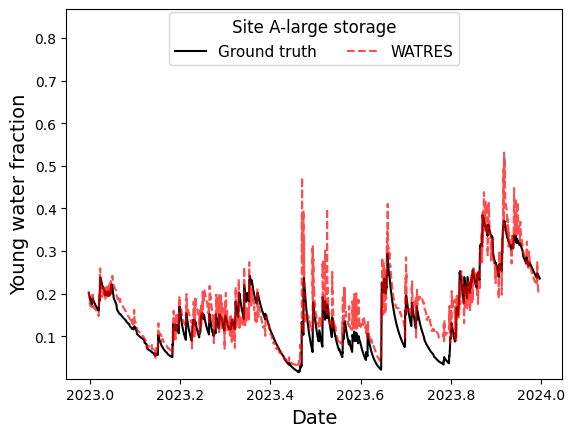

Pully_small_storage
Pully_large_storage


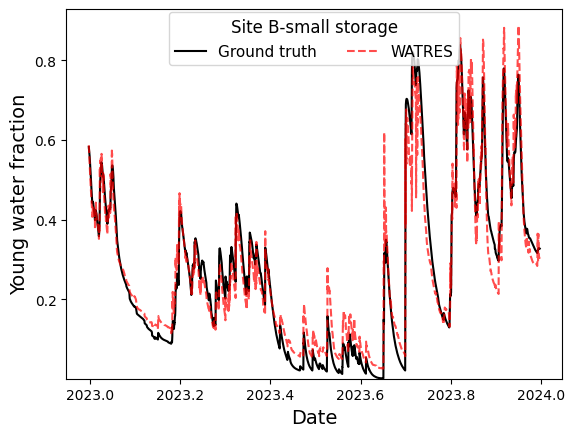

Pully_small_storage
Pully_large_storage


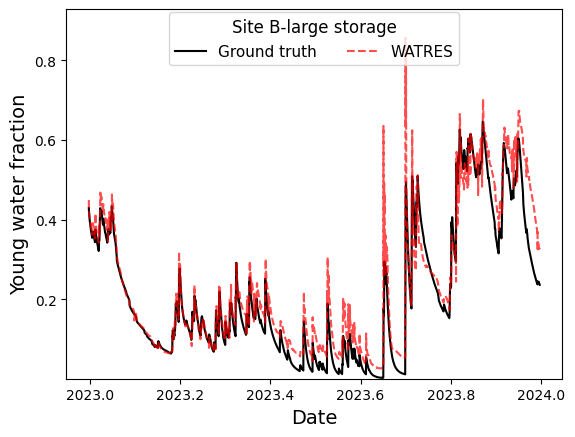

Lugano_small_storage
Lugano_large_storage


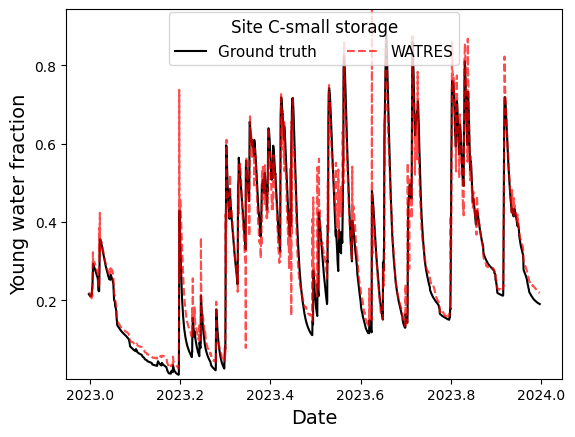

Lugano_small_storage
Lugano_large_storage


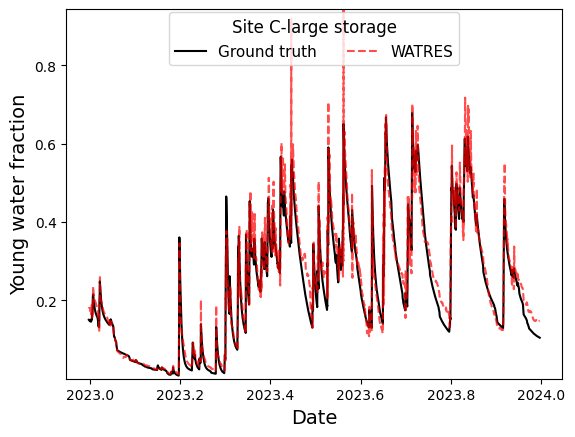

In [165]:
show_TS_ywf(results, algo2name=algo2name, site2name = site2name)

# 2. Global TTD

In [111]:
def show_global_cum_ttd(results, algo2name=None, site2name=None):
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    #colors = {'WATRES': 'red', 'J-weighted': 'orange', 'Weibull': 'blue', 'MESAS':'brown', 'EHS':'green'}
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    x_abs = np.arange(365*24)/(24*30)
    count_fig = 0
    for site, res_site in results.items():
        count_algo = 0
        for algo, value in res_site.items():
            plt.figure(count_fig)
            if algo in ['EHS', 'MESAS']:
                x_temp = results[site][algo]['TTD_lag']
                idxs = np.where(x_temp<=365*24)[0]
                plt.plot(x_temp[idxs]/(24*30), results[site][algo]['globalPQ'][idxs], color=color[algo], label=algo2name[algo])
            else:
                plt.plot(x_abs, results[site][algo]['global_PQhat'][:365*24], color=color[algo], label=algo2name[algo])
            if count_algo==0:
                plt.plot(x_abs, results[site][algo]['global_PQtrue'][:365*24], label='Ground truth', linestyle='--', color='black')
            plt.xlabel('Age (in Months)', fontsize=13)
            plt.ylabel('Averaged cumulative TTD', fontsize=14)
            plt.legend()
            plt.title(site2name[site], fontsize=14)
            count_algo += 1
        plt.savefig('comparison_global_ttd_{0}.png'.format(site2name[site]), dpi=250, bbox_inches="tight")
        plt.show()
        count_fig += 1

In [80]:
results['Basel_large_storage']['SumSquares_noBERT2']['global_PQtrue'].shape, 24*365

((8760,), 8760)

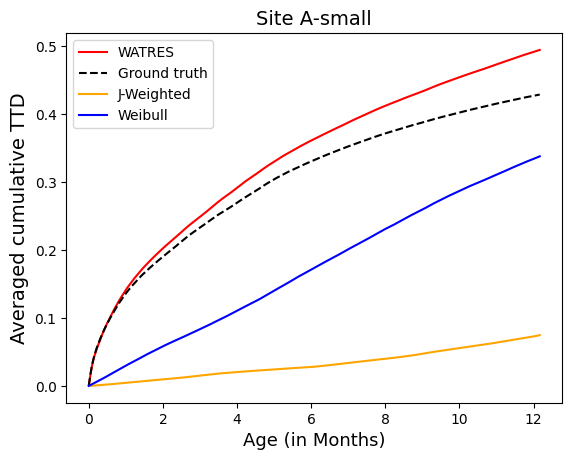

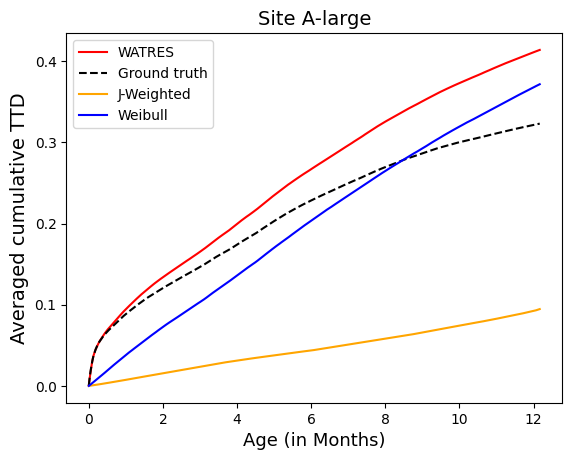

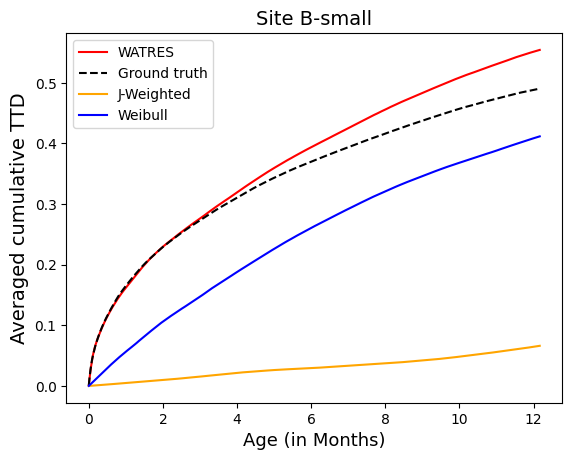

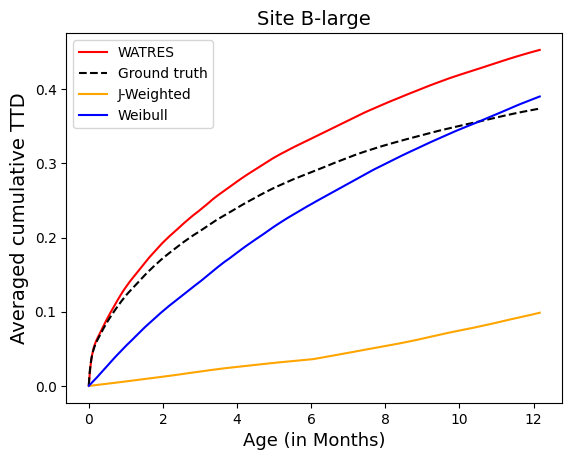

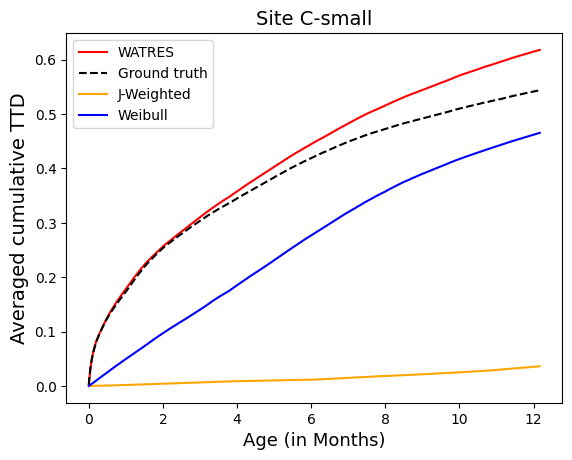

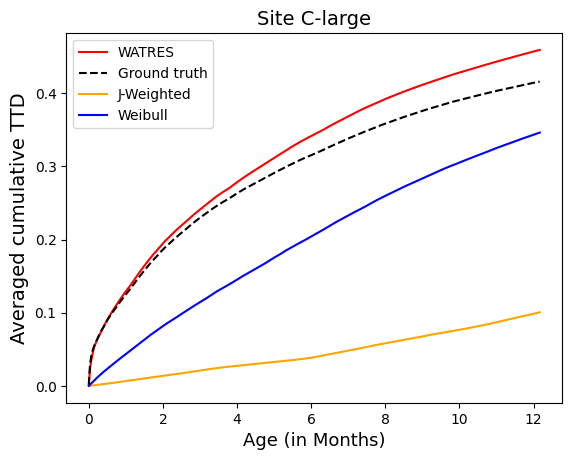

In [112]:
show_global_cum_ttd(results, algo2name=algo2name, site2name=site2name)

In [114]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def show_global_cum_ttd_row(results, algo2name=None, site2name=None):
    # Default mapping for site names
    if site2name is None:
        site2name = {el: el for el in results.keys()}
    
    # Default mapping for algorithm names
    if algo2name is None:
        algo2name = {el: el for el in results[list(results.keys())[0]].keys()}
    
    # Define colors and markers
    colors = ['Teal',  'Coral']
    markers = ['*', '.', 'o', '^', 's', 'd']
    
    # X-axis values for plotting
    x_abs = np.arange(365 * 24) / (24 * 30)
    
    # Count for subplot management
    count = 0
    num_sites = len(results)
    num_cols = 3  # Number of columns for subplots
    num_rows = 1
    
    # Create a figure for subplots
    plt.figure(figsize=(15, 5 * num_rows))

    titles = ['Site A', 'Site B', 'Site C']
    for site, res_site in results.items():
        if count%2==0:
            plt.subplot(num_rows, num_cols, count//2 + 1)
            legend_patches = []
            legend_patches.append(Patch(facecolor=colors[0], edgecolor='black', label=sitenames[count][:6]+' small storage'))
            legend_patches.append(Patch(facecolor=colors[1], edgecolor='black', label=sitenames[count][:6]+' large storage'))


        
        # Check if the algorithm and required keys exist
        algo = 'SumSquares_noBERT2_bayesian3'
        if algo not in res_site or 'global_PQhat' not in res_site[algo] or 'global_PQtrue' not in res_site[algo]:
            print(f"Missing data for site: {site} or algorithm: {algo}")
            count += 1
            continue
        
        # Plot predicted and true cumulative TTD
        plt.plot(
            x_abs, 
            res_site[algo]['global_PQhat'][:365 * 24], 
             linestyle='--', 
            color=colors[count%2]
        )
        plt.plot(
            x_abs, 
            res_site[algo]['global_PQtrue'][:365 * 24], 
            color=colors[count%2]
        )
        if count%2==1:    
            # Set axis labels and title
            plt.xlabel('Age (in Months)', fontsize=13)
            plt.ylabel('Averaged cumulative TTD', fontsize=14)
            plt.title(titles[count//2], fontsize=14)
            plt.ylim(top=1)
            # Add the GISID color blocks to the legend
            ax = plt.gca()
            gisid_legend = ax.legend(handles=legend_patches, loc='upper right', fontsize=12)
            
            method_legend_lines = [
                Line2D([0], [0], color='black', linestyle='--', lw=1, label='WATRES'),
                Line2D([0], [0], color='black', lw=1, label='Ground truth')
            ]
            method_legend = ax.legend(handles=method_legend_lines, loc='upper left', fontsize=12)
            ax.add_artist(gisid_legend)  # Add GISID legend manually so it doesn't get overwritten


        
        count += 1
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig('global_ttd_watres_gt.png'.format(site2name[site]), dpi=250, bbox_inches="tight")

    plt.show()


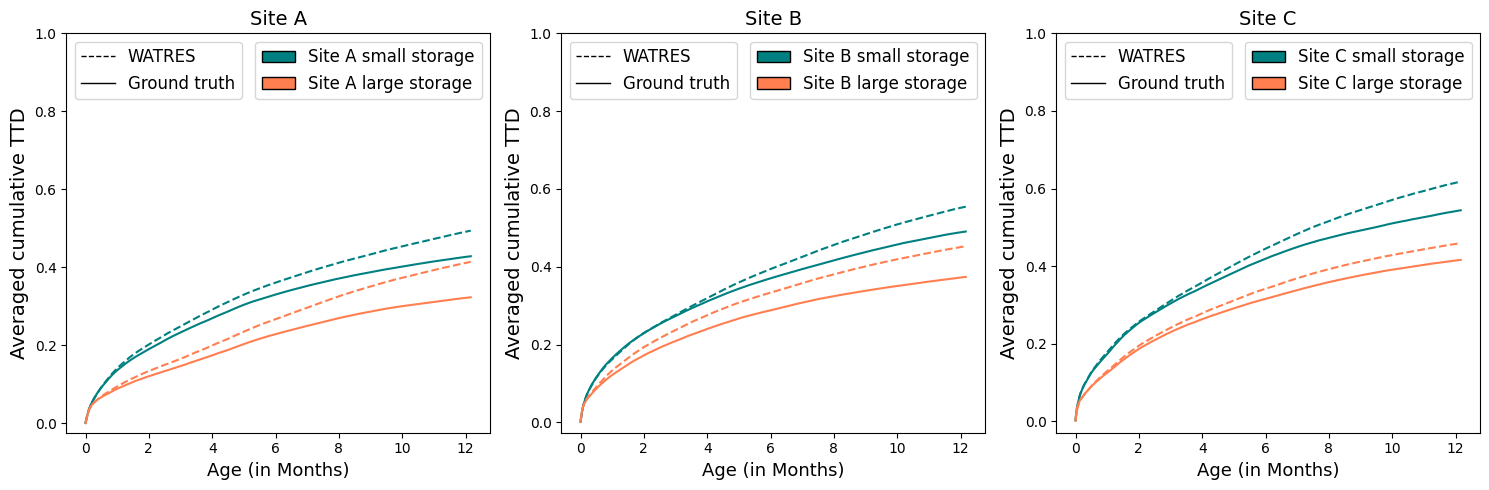

In [115]:
show_global_cum_ttd_row(results, algo2name=algo2name, site2name=site2name)

# 3. Violin plots

In [125]:
def show_violin_ywf(results, algo2name=None, site2name=None):
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    count_fig = 0
    count_algo = 0
    algo2name = get_names_algos(results, algo2name)
    algo1 = list(algo2name.keys())[0]
    idxalgo = 0
    for algo, name_algo in algo2name.items():
        if algo!='EHS':
            idxalgo += 1
            dataset = []
            lsywf = []
            real_or_esti = []
            tickslabel = []
            plt.figure(num=idxalgo, figsize=(10,5))
        
            for site, res_site in results.items():
                esti_ywf = res_site[algo]['ywfhat'][:,2]
                dataset += [site]*2*len(esti_ywf)
                lsywf += list(esti_ywf)
                true_ywf = res_site[algo1]['ywf_true'][:,2]
                lsywf += list(true_ywf)
                real_or_esti += ['Predicted']*len(esti_ywf)
                real_or_esti += ['Ground truth']*len(esti_ywf)
                tickslabel.append(site2name[site])
        
            df = {'Dataset': dataset, 'Young water fraction': lsywf, 'real_or_esti':real_or_esti}
        
            sns.violinplot(data=df, x="Dataset", y="Young water fraction", hue="real_or_esti", split=True, width=1.3)
            plt.xticks(list(range(0,len(tickslabel))), tickslabel, rotation = 90, fontsize=13)
            plt.legend(fontsize=14,ncol=2)
            plt.title('Model: '+name_algo, fontsize=14)
            plt.savefig('comparison_violin_{0}.png'.format(name_algo), dpi=250, bbox_inches="tight")
            plt.show()

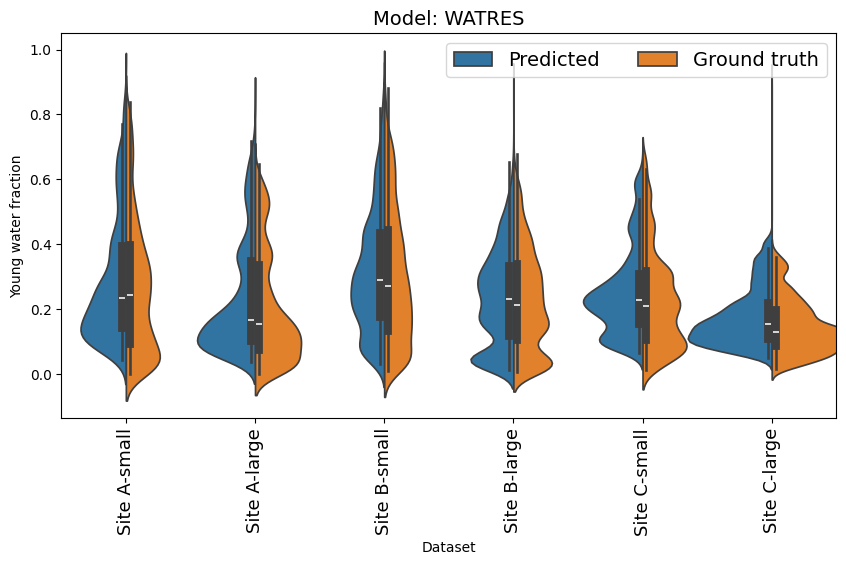

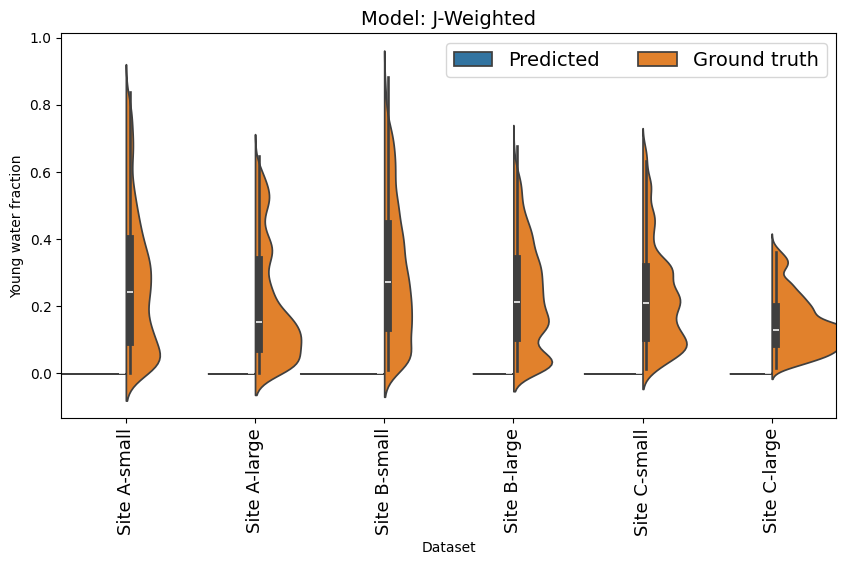

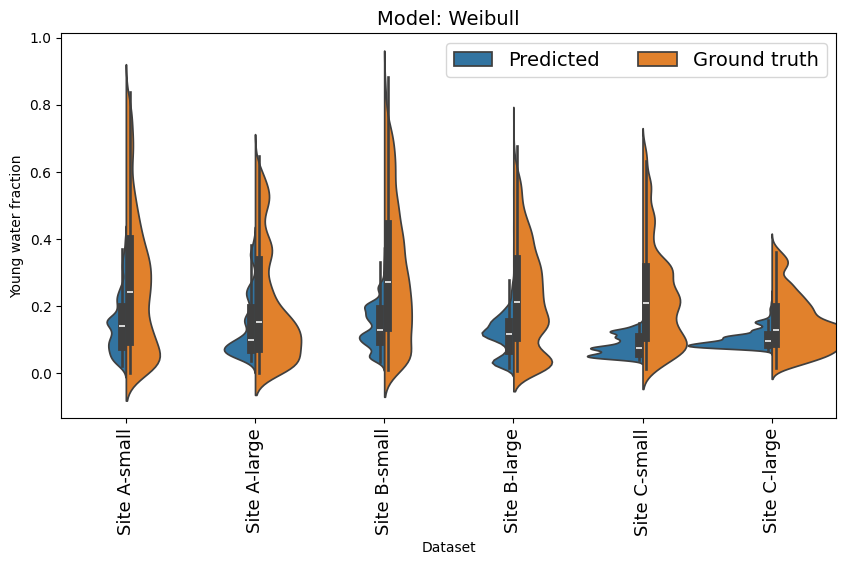

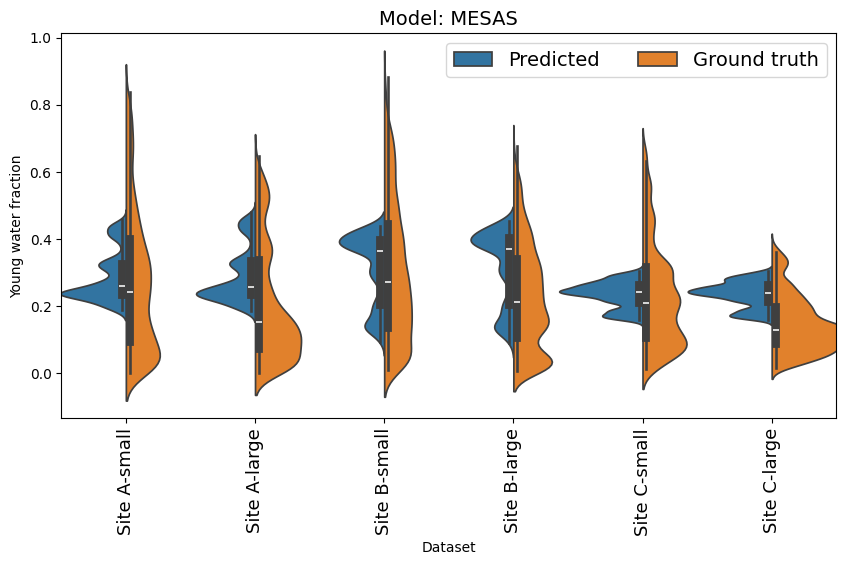

In [126]:
show_violin_ywf(results, algo2name=algo2name, site2name=site2name)

In [144]:
sites

['Basel_small_storage',
 'Basel_large_storage',
 'Pully_small_storage',
 'Pully_large_storage',
 'Lugano_small_storage',
 'Lugano_large_storage']

In [116]:
def show_violin_ywf_ground_truth(results, algo2name=None, site2name=None):
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    count_fig = 0
    count_algo = 0
    algo2name = get_names_algos(results, algo2name)
    algo1 = list(algo2name.keys())[0]
    idxalgo = 0
    dataset = []
    lsywf = []
    real_or_esti = []
    tickslabel = []
    plt.figure(num=idxalgo, figsize=(8,4))
    algo = 'SumSquares_noBERT2_bayesian3'
    colors = ['Teal',  'Coral']
    labels = ['Site A', 'Site B', 'Site C']
    for count, cat in enumerate(['Basel','Pully','Lugano']):
        esti_ywf = results[cat+'_small_storage'][algo]['ywf_true'][:,2]
        dataset += [cat]*2*len(esti_ywf)
        lsywf += list(esti_ywf)
        true_ywf = results[cat+'_large_storage'][algo]['ywf_true'][:,2]
        lsywf += list(true_ywf)
        real_or_esti += ['Small storage']*len(esti_ywf)
        real_or_esti += ['Large storage']*len(esti_ywf)
        tickslabel.append(labels[count])
        
    df = {'Dataset': dataset, 'Young water fraction': lsywf, 'real_or_esti':real_or_esti}

    sns.violinplot(data=df, x="Dataset", y="Young water fraction", hue="real_or_esti", split=True, width=1, palette={"Small storage": colors[0], "Large storage": colors[1]})
    plt.xticks(list(range(0,len(tickslabel))), tickslabel, rotation = 90, fontsize=13)
    plt.legend(fontsize=14,ncol=2)
    #plt.title('Distribution of the ground truth young water fraction', fontsize=14)
    plt.savefig('distribution_ywf_gt.png', dpi=250, bbox_inches="tight")
    plt.show()

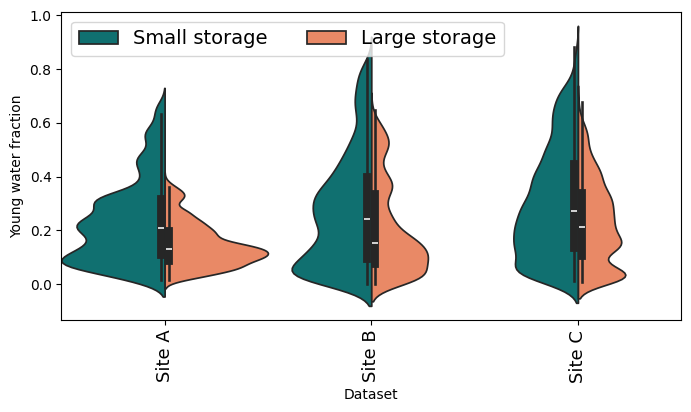

In [117]:
show_violin_ywf_ground_truth(results, algo2name=algo2name, site2name=site2name)

# Errors reproduced output tracer

In [118]:
def show_errors(results, algo2name=None, err='ERROR_Cout', site2name=None, MSE=False):
    size_marker = 100
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    markers = ['*','+', 'x', '.', 'd','|']
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    tickslabel = []
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        count_algo = 0
        for algo, value in res_site.items():
            if MSE:
                error = value['ERROR_Cout']
            else:
                error = np.mean(np.abs(value['Cout'].numpy()-value['Chat']))
            if not(algo in ['EHS']):
                if count_fig==1:
                    plt.scatter([count_fig], np.log10(error), label=algo2name[algo], marker=mark[algo], c=color[algo], s=size_marker, alpha=1)
                else:
                    plt.scatter([count_fig], np.log10(error), marker=mark[algo], c=color[algo], s=size_marker, alpha=1)
                count_algo += 1

        tickslabel.append(site2name[site])
        
    plt.xticks(list(range(1,count_fig+1)), tickslabel, rotation = 90, fontsize=13)
    plt.legend(
        fontsize=12,
        loc='center',         # Position legend to the left center
        bbox_to_anchor=(0.5, 1.07),   # Move it outside the plot, centered vertically
        ncol=3                     # Set the number of columns
    )
    if MSE:
        plt.ylabel('$Log_{10}($ RMSE on the reproduced $C_Q)$', fontsize=14)
    else:
        plt.ylabel('$Log_{10}($ Absolute error on the reproduced $C_Q)$', fontsize=14)
    plt.savefig('comparison_Cq.png', dpi=250, bbox_inches="tight")
    plt.show()

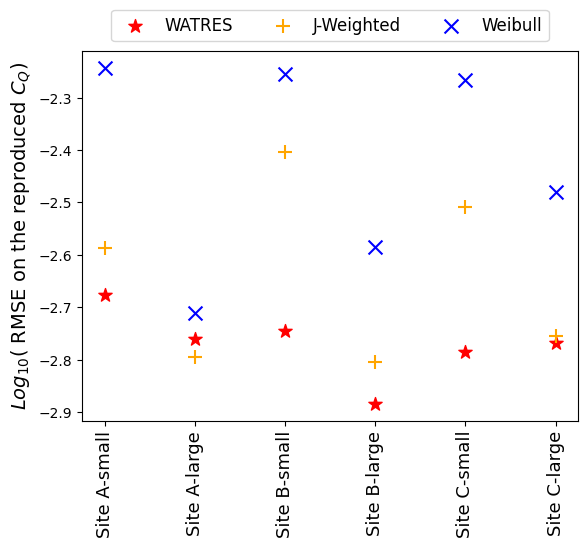

In [178]:
show_errors(results, algo2name=algo2name, site2name=site2name, MSE=True)

# 4. Young water fraction by quantiles

In [204]:
def show_quantile_ywf_single_figure(results, nb_groups = 10, months_ywf=3, algo2name=None, site2name=None):
    from matplotlib.lines import Line2D
    if site2name is None:
        site2name = list(results.keys())
    count_site = -1
    algo2name = get_names_algos(results, algo2name)
    colors = np.flip(get_colors_rainbow(K=nb_groups))
    markers = ["o", "s", "D", "*", "X", "v", "P"]

    min_val_glob, max_val_glob = 1, 0
    for site, res_site in results.items():
        count_site += 1
        algo = 'SumSquares_noBERT2_bayesian3'
        value = res_site[algo]
        Q_test = value['Q_test']
        # Get quantile bins (10 quantiles)
        quantile_bins = np.quantile(Q_test, np.linspace(0, 1, nb_groups+1))
        # Assign each value to a quantile bin
        quantile_indexes = np.digitize(Q_test, quantile_bins, right=True)
        # Create a dictionary to hold the indexes for each group
        grouped_indexes = {i: np.where(quantile_indexes == i)[0] for i in range(1, nb_groups+1)}

        data_pred = []
        data_true = []
        
        for idx_group, idxs in grouped_indexes.items():
            if len(idxs) > 0:
                data_pred.append(np.mean(value['ywfhat'][:, months_ywf-1][idxs]))
                data_true.append(np.mean(value['ywf_true'][:, months_ywf-1][idxs]))

        # Find the axis limits based on the data
        all_data = np.concatenate((data_pred, data_true))
        min_val, max_val = np.min(all_data), np.max(all_data)
        max_val_glob = max([max_val_glob, max_val])
        min_val_glob = min([min_val_glob, min_val])

        
        # Plot with different colors for each group and create a legend entry
        for i in range(1, nb_groups+1):
            if i in grouped_indexes and len(grouped_indexes[i]) > 0:
                plt.scatter(
                    np.mean(value['ywfhat'][:, months_ywf-1][grouped_indexes[i]]),
                    np.mean(value['ywf_true'][:, months_ywf-1][grouped_indexes[i]]),
                    color=colors[i-1],
                    marker=markers[count_site]
                )
    

    min_val_glob -= 0.05
    min_val_glob = max([min_val_glob,0])
    max_val_glob += 0.05
    # Set the same limits for x and y axes
    plt.xlim(min_val_glob, max_val_glob)
    plt.ylim(min_val_glob, max_val_glob)
    plt.plot([min_val_glob, max_val_glob], [min_val_glob, max_val_glob], linestyle='--', color='black')
    plt.xlabel('Predicted young water fraction', fontsize=13)
    plt.ylabel('Ground truth young water fraction', fontsize=14)
    # Custom legend for colors (Streamflow quantiles)
    color_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i-1], markersize=10)
                    for i in range(1, nb_groups+1)]
    quantile_legend = plt.legend(color_legend, [f'Q{i}' for i in range(1, nb_groups+1)], 
                                 title="Streamflow quantiles",
                                 loc=5, bbox_to_anchor=(0.93, 0.2), ncol=2)
    
    # Add the color legend to the plot
    plt.gca().add_artist(quantile_legend)

    # Custom legend for markers (Sites)
    marker_legend = [Line2D([0], [0], marker=markers[i], color='w', markerfacecolor='grey', markersize=10)
                     for i in range(len(site2name))]
    plt.legend(marker_legend, site2name.values(), title="Sites", loc=1, bbox_to_anchor=(0.6, 0.95), ncol=2)

    plt.tight_layout()
    plt.savefig('ywf_true_vs_pred.png', dpi=250, bbox_inches="tight")
    plt.show()

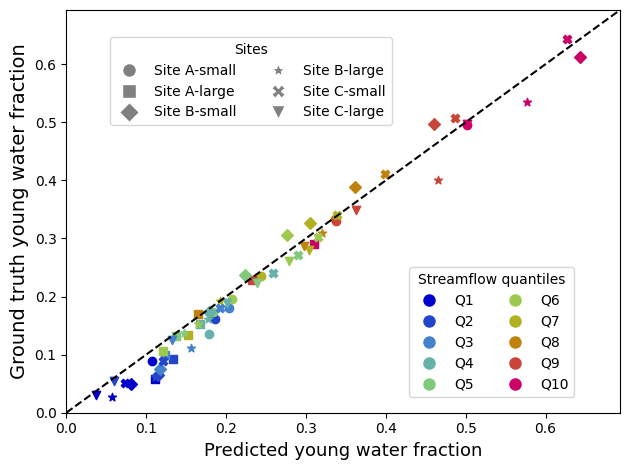

In [205]:
show_quantile_ywf_single_figure(results, site2name=site2name, nb_groups=10)

In [129]:
def show_quantile_ywf(results, nb_groups = 10, months_ywf=3, algo2name=None, site2name=None):
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    count = 0
    algo2name = get_names_algos(results, algo2name)
    colors = np.flip(get_colors_rainbow(K=nb_groups))
    markers = ['*','+', 'x', '.', 'd','|']
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    algo1 = list(algo2name.keys())[0]
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    count_fig = 0
    for site, res_site in results.items():
        plt.figure(count_fig)
        q_true = np.zeros(4)
        for k in range(4):
            q_true[k] = res_site[algo1]['quantile{0}_PQtrue'.format(k)][24*(months_ywf)]
        all_qs = list(q_true)
        for algo, value in res_site.items():
            if algo in ['EHS', 'MESAS']:
                q_esti = np.zeros(4)
                for k in range(4):
                    q_esti[k] = value['quantile{0}_ywfhat'.format(k)][months_ywf-1]
            else:
                q_esti = np.zeros(4)
                for k in range(4):
                    q_esti[k] = value['quantile{0}_PQhat'.format(k)][24*(months_ywf)]
            all_qs += list(q_esti)
            # Plot with different colors for each group and create a legend entry
            for i in range(4):
                if i==0:
                    plt.scatter(
                        q_esti[i],
                        q_true[i],
                        color=color[algo],
                        marker=mark[algo],
                        label=algo2name[algo]
                    )
                else:
                    plt.scatter(
                        q_esti[i],
                        q_true[i],
                        color=color[algo],
                        marker=mark[algo]
                    )

        # Set the same limits for x and y axes
        min_val = np.min(all_qs)
        max_val = np.max(all_qs)
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.plot([min_val,max_val],[min_val,max_val], linestyle='--', c='black')
        plt.xlabel('Predicted', fontsize=13)
        plt.ylabel('Ground truth', fontsize=14)
        plt.legend(title='Model')
        plt.title('{0}'.format(site2name[site]), fontsize=14)
        plt.show()
        count += 1

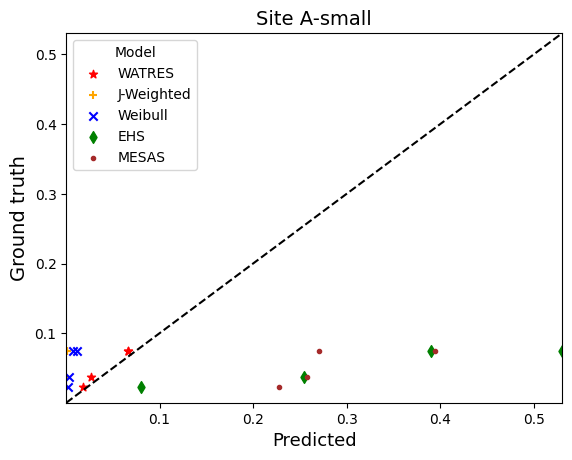

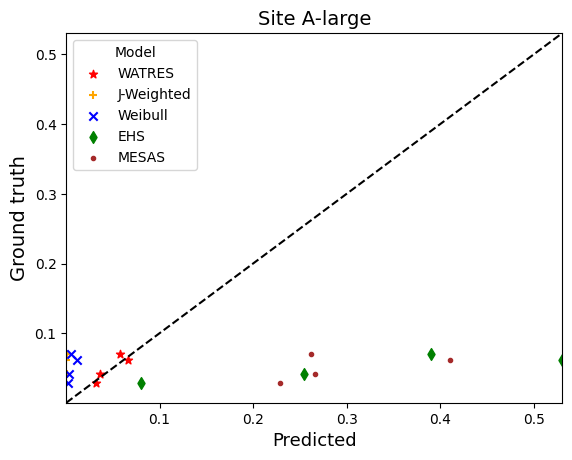

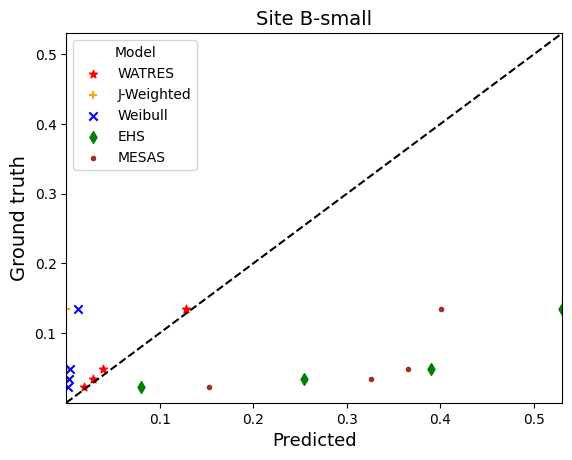

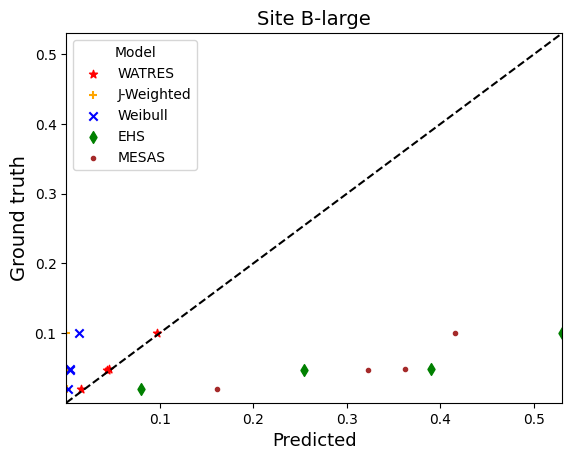

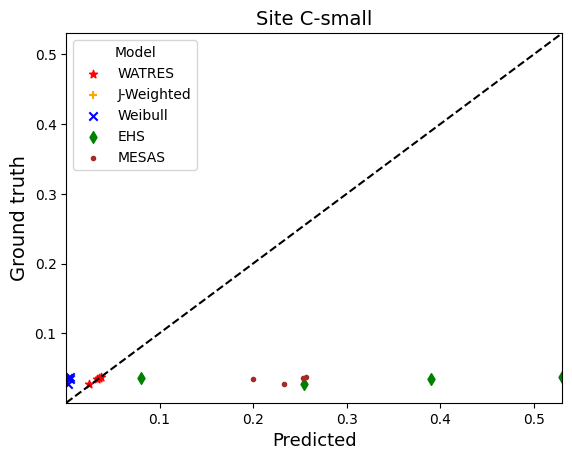

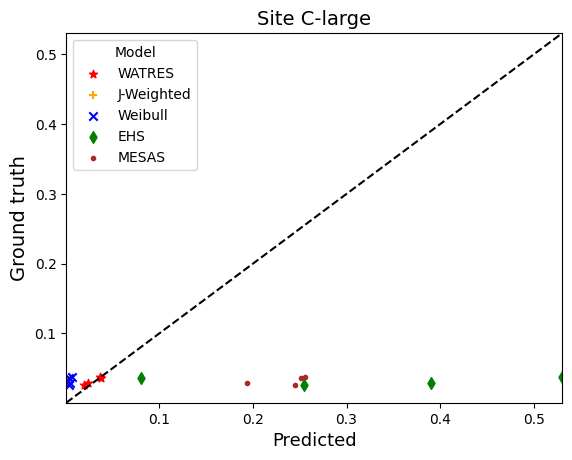

In [130]:
show_quantile_ywf(results, algo2name=algo2name, site2name=site2name)

### Results on the total test set

In [173]:

def show_Cout(settings_algos, n_start=0, n_end=-1, algo2name=None, scatter=False):
    algo2name = get_names_algos(settings_algos, algo2name)
    for i in range(len(settings_algos)):
        site = settings_algos[i]['site']
        algo = settings_algos[i]['algo']
        if algo2name[algo]=='WATRES':
            with open(settings_algos[i]['path_results'], "rb") as input_file:
                result = pickle.load(input_file)  
            fig, ax = plt.subplots()
            ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
            lst_test = result['timeyear_test'][:n_end][n_start:]
            if scatter:
                plt.scatter(lst_test, result['Chat'][:n_end][n_start:], c='red')
            plt.plot(lst_test, result['Chat'][:n_end][n_start:],  c='red', linestyle='--', label='WATRES')
            if scatter:
                plt.scatter(lst_test, result['Cout'][:n_end][n_start:],  c='black')
            plt.plot(lst_test, result['Cout'][:n_end][n_start:],  c='black',  label='Ground truth')
            legend = plt.legend(
                title=site2name[site]+' storage',
                fontsize=11,
                loc='center',         # Position legend to the left center
                bbox_to_anchor=(0.5, 0.92),   # Move it outside the plot, centered vertically
                ncol=2                     # Set the number of columns
            )
            legend.get_title().set_fontsize('12') #legend 'Title' fontsize
    
            #plt.title(site2name[site], fontsize=14)
        
            plt.xlabel('Date', fontsize=14)
            plt.ylabel('Output tracer', fontsize=14)

            # y limits
            site_letter = site2name[site][:7]
            bottom = float('inf')
            top = -float('inf')
            for j in range(len(settings_algos)):
                site_ylim = settings_algos[j]['site']
                if site_letter in site2name[site_ylim]:
                    with open(settings_algos[j]['path_results'], "rb") as input_file:
                        result = pickle.load(input_file) 
                    bottom = np.min([bottom,np.min(np.array(result['Chat'][:n_end][n_start:]))])
                    bottom = np.min([bottom,np.min(np.array(result['Cout'][:n_end][n_start:]))])
                    top = np.max([top,np.max(np.array(result['Chat'][:n_end][n_start:]))])
                    top = np.max([top,np.max(np.array(result['Cout'][:n_end][n_start:]))])
            plt.ylim(bottom, top)
            plt.savefig(f'watres_reproduced_cq_{site2name[site]}.png', dpi=250, bbox_inches="tight")
            plt.show()


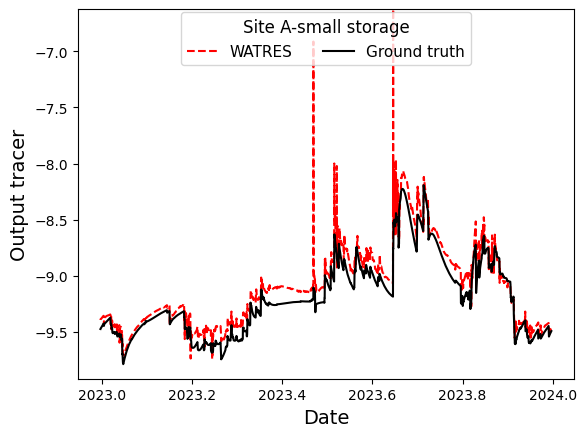

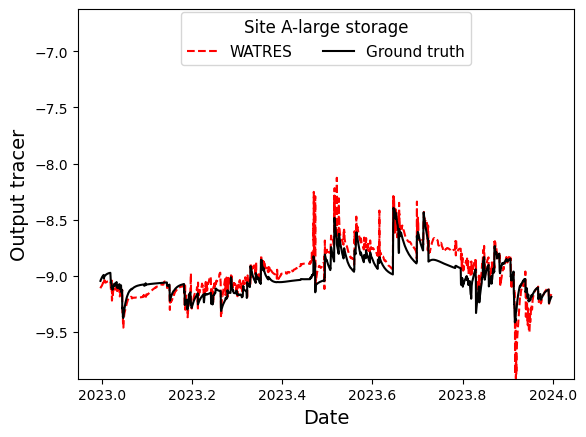

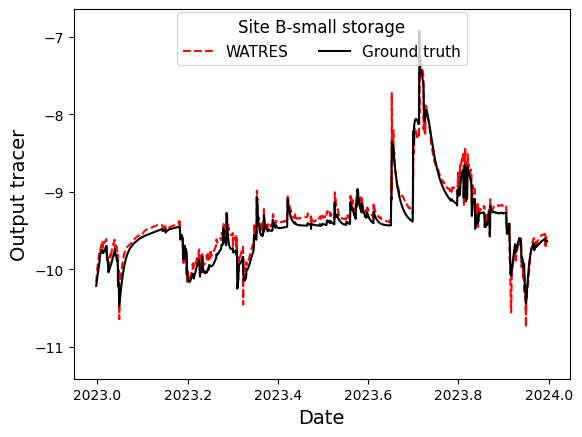

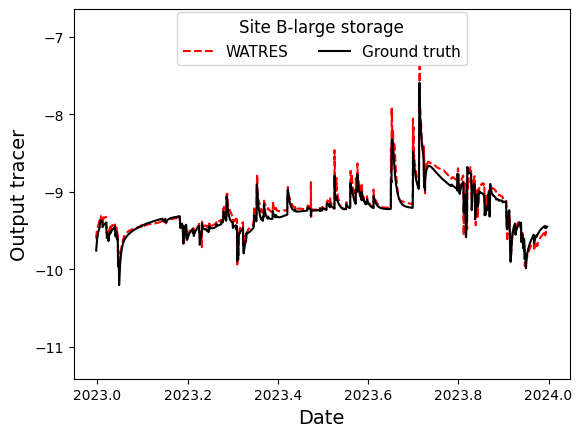

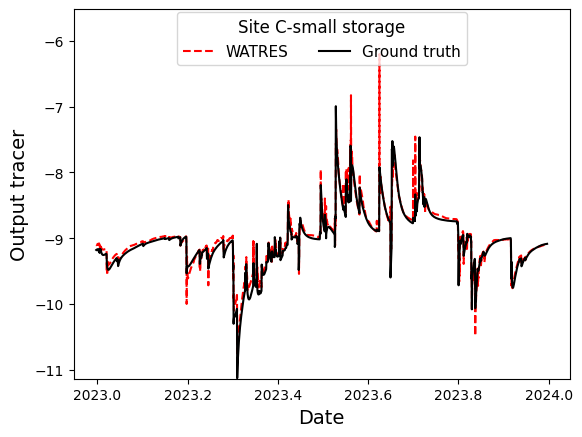

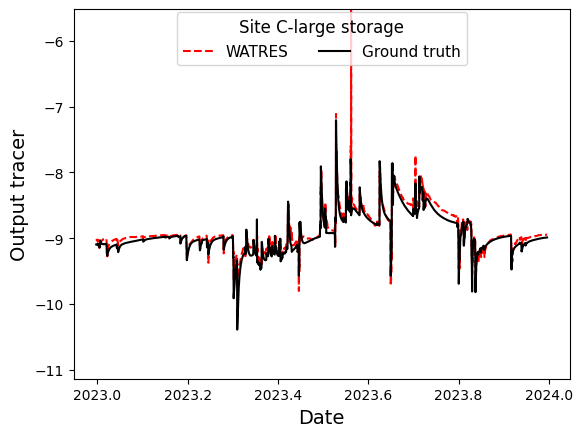

In [174]:
show_Cout(settings, algo2name=algo2name)

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_49942/488748613.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$T\mapsto Log_{10}(w_{season}(T))$', fontsize=14)


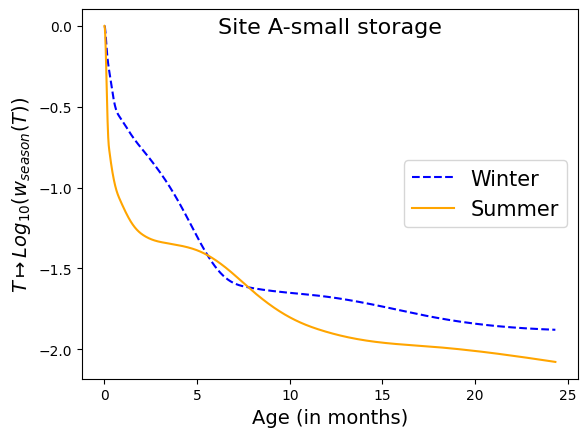

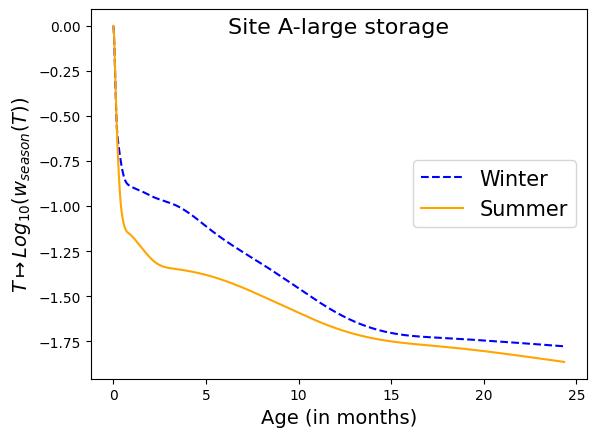

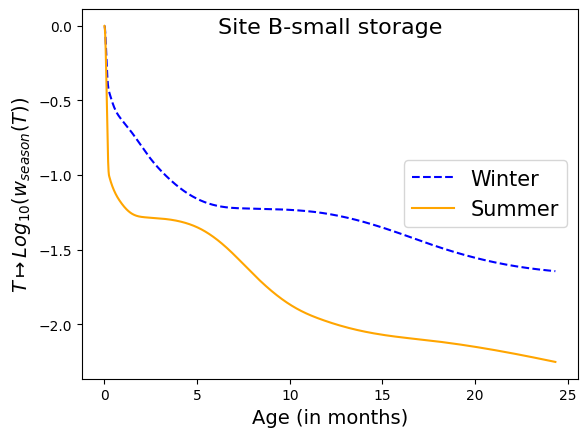

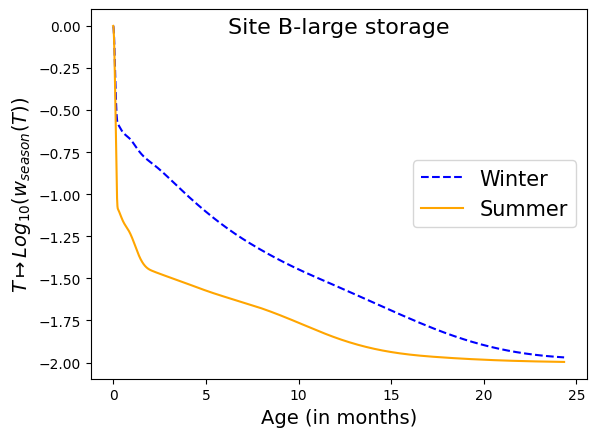

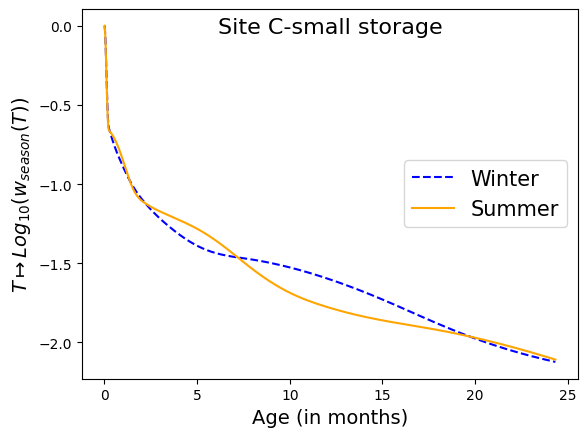

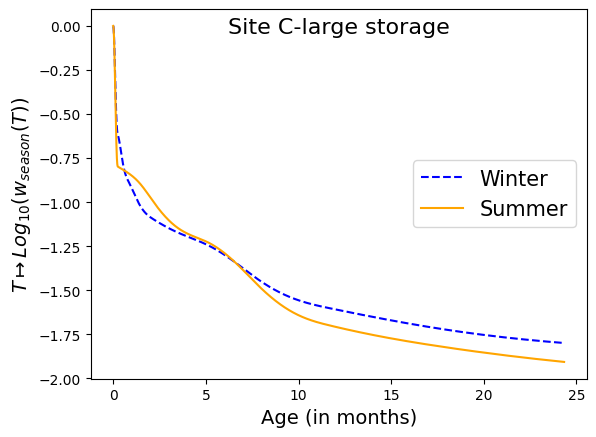

In [203]:
algo = 'SumSquares_noBERT2_bayesian3'
for site in sites:
    plt.plot(np.arange(2*24*365)/(24*30), np.log10(results[site][algo]['w_winter'][:2*24*365]), linestyle='--', color='blue', label='Winter')
    plt.plot(np.arange(2*24*365)/(24*30), np.log10(results[site][algo]['w_summer'][:2*24*365]), color='orange', label='Summer')
    plt.legend(fontsize=15, loc='center right')
    plt.xlabel('Age (in months)', fontsize=14)
    plt.ylabel('$T\mapsto Log_{10}(w_{season}(T))$', fontsize=14)
    ax = plt.gca()
    ax.set_title(site2name[site]+' storage', y=1.0, pad=-17, fontsize=16)
    plt.savefig(f'w_season_{site2name[site]}.png',  dpi=250, bbox_inches="tight")
    plt.show()

### Zooming on a subset of the test set

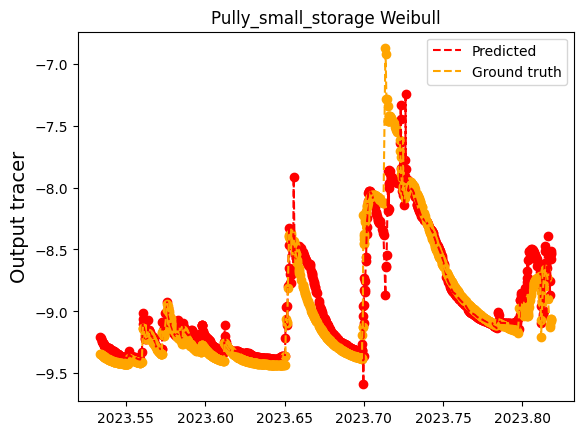

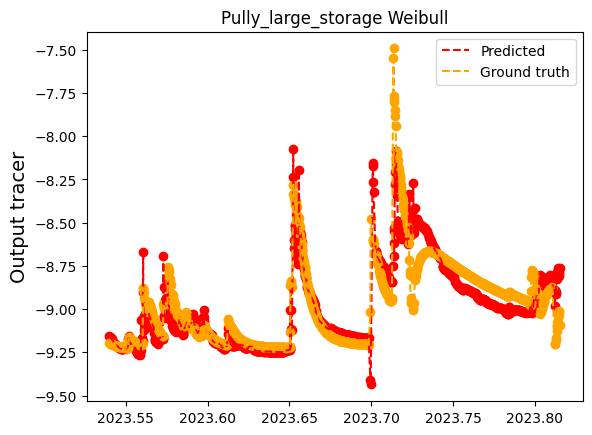

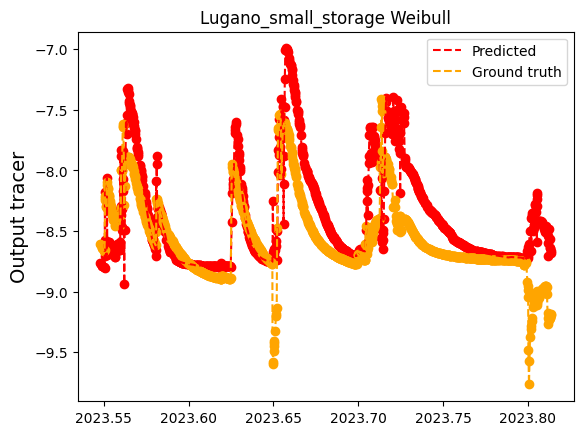

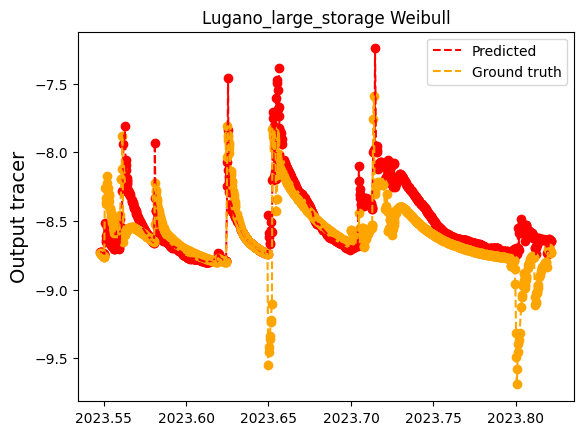

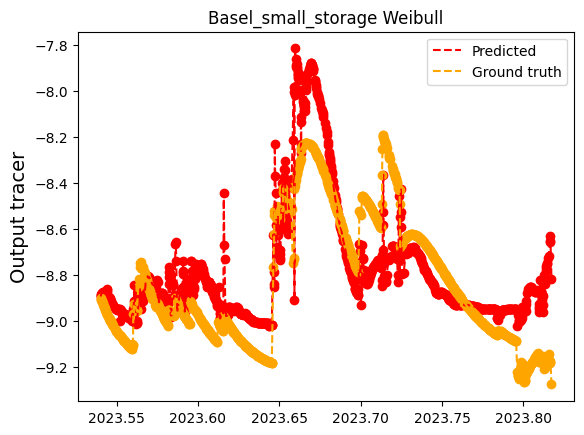

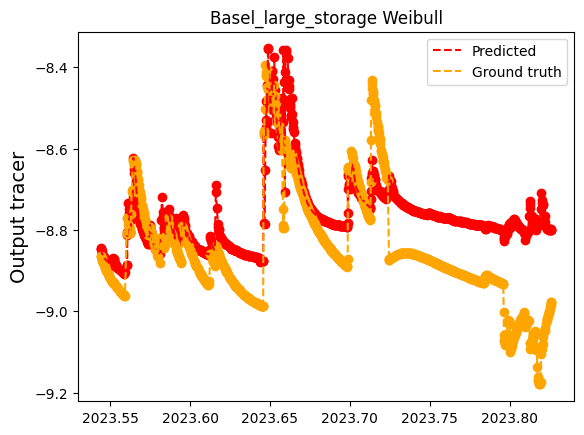

In [14]:
show_Cout(settings, n_start=2000, n_end=3000, algo2name=algo2name)

# 2. Estimated Young Water Fraction

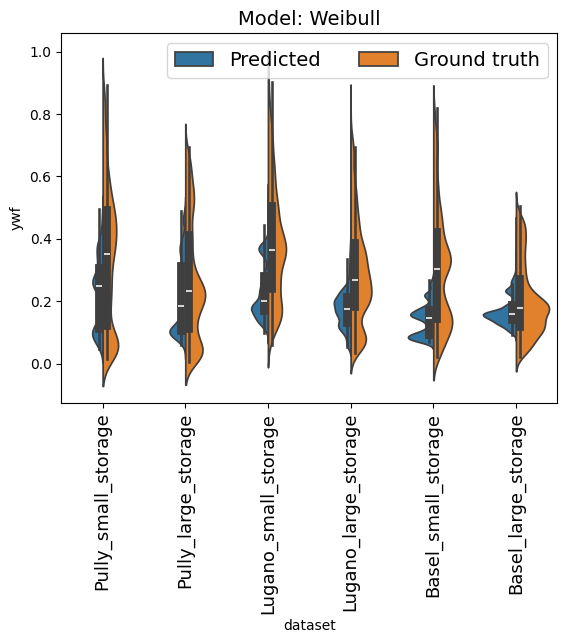

In [15]:
show_violin_ywf(results, algo2name=algo2name)

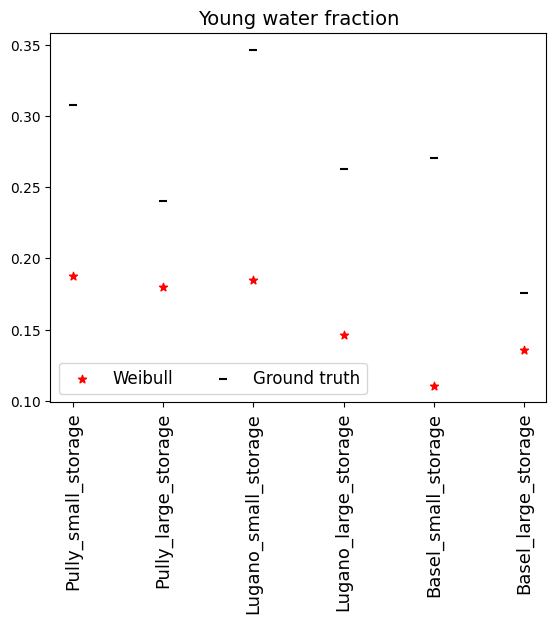

In [16]:
show_ywf(results, algo2name=algo2name)

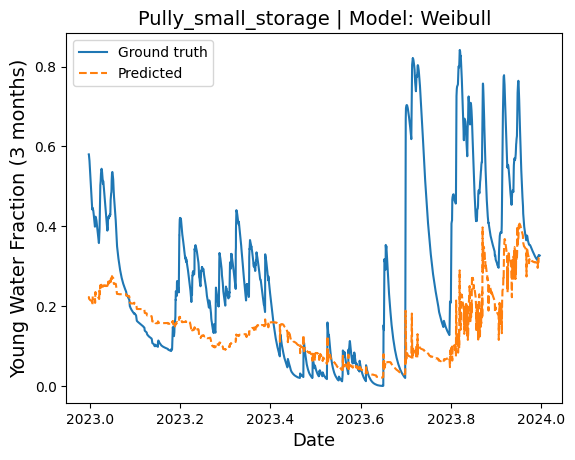

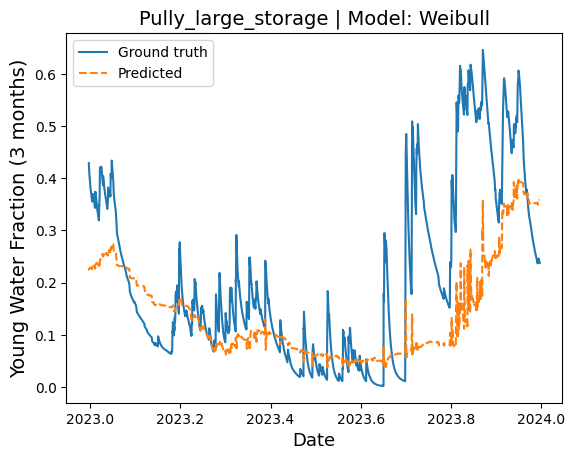

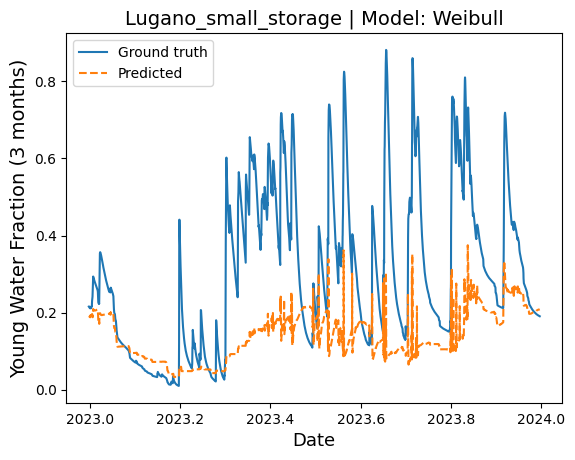

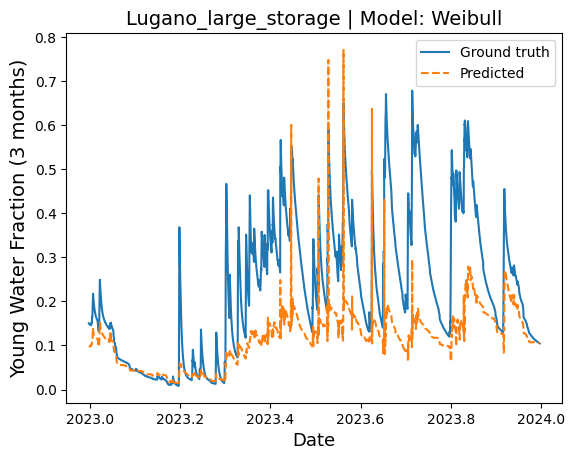

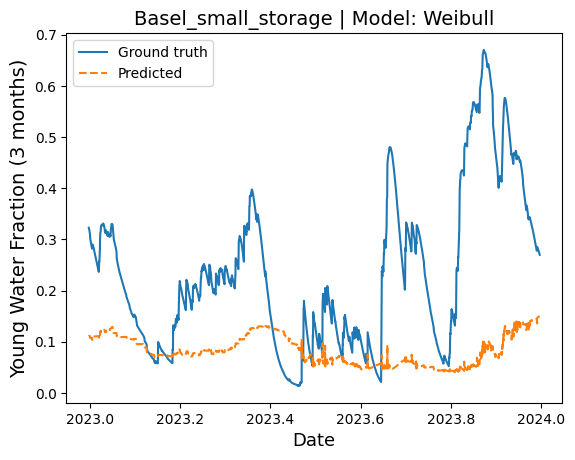

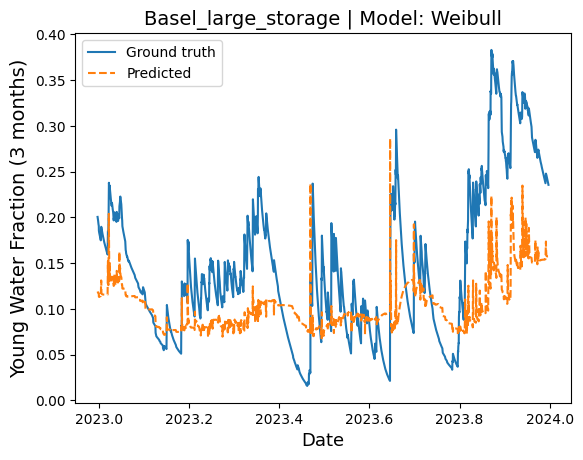

In [17]:
show_TS_ywf(results, algo2name=algo2name)

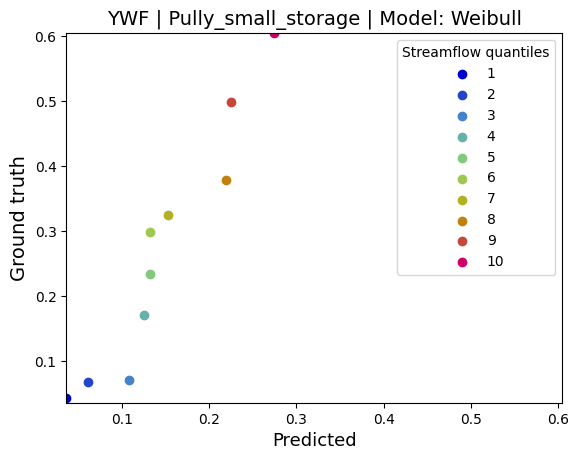

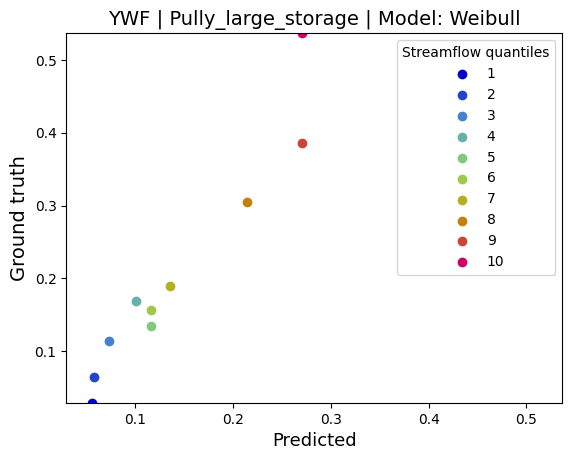

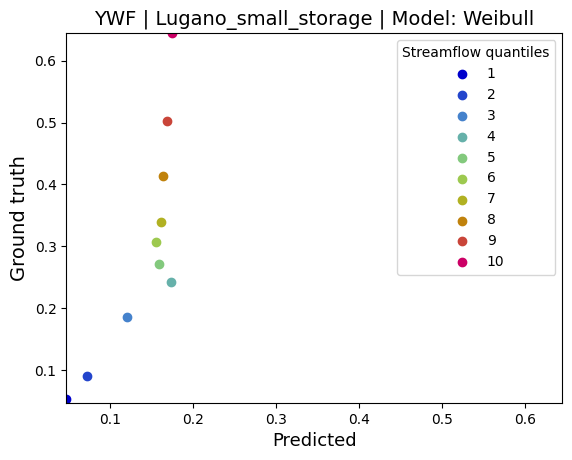

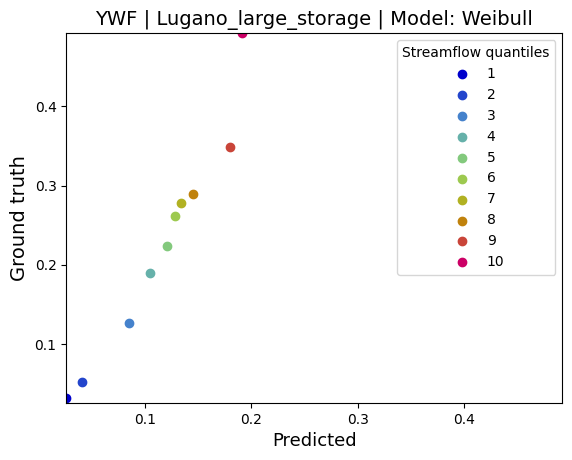

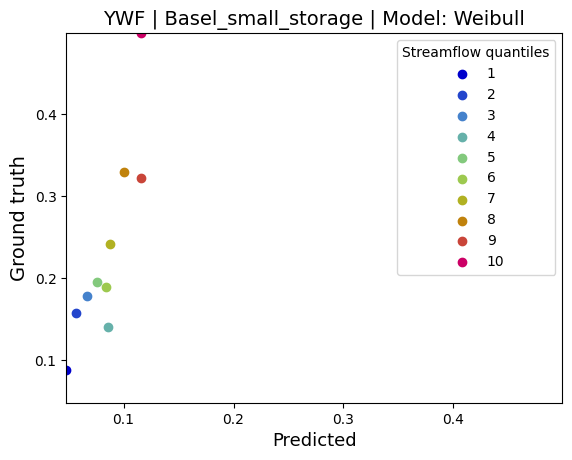

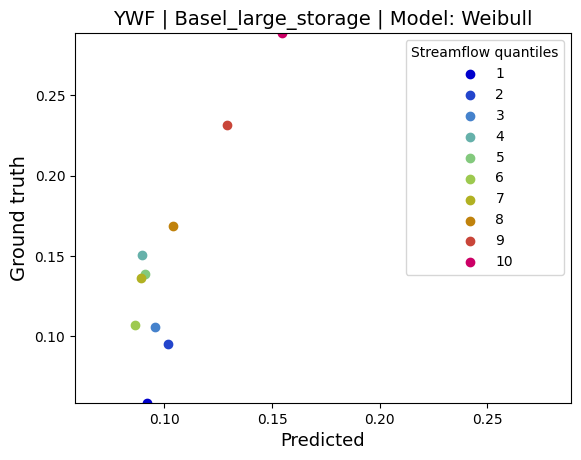

In [18]:
show_quantile_ywf(results)

# 3. Cumulative TTDs

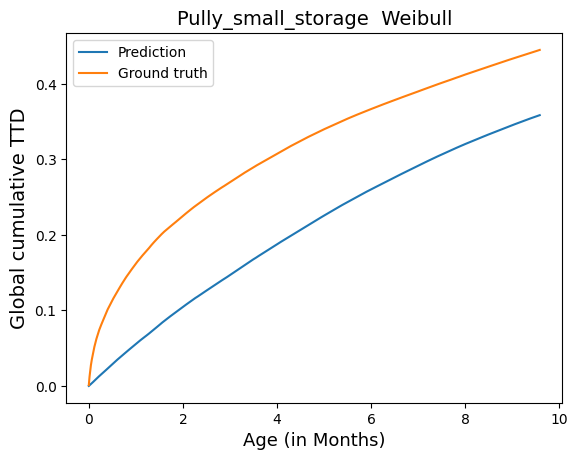

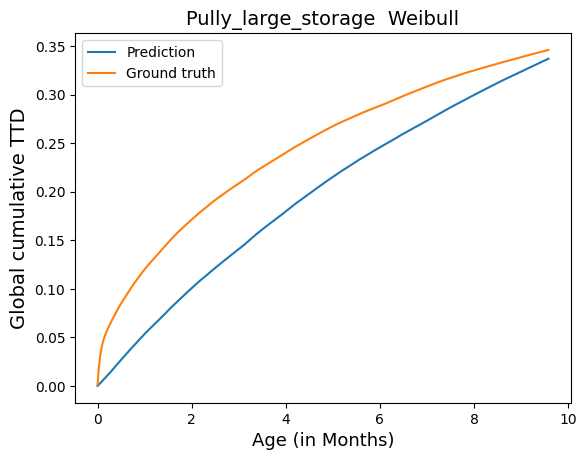

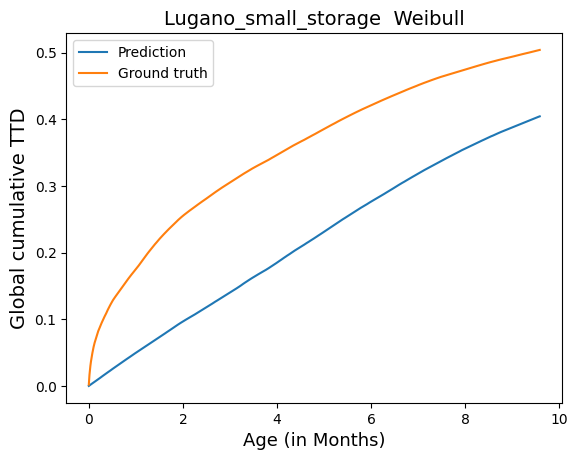

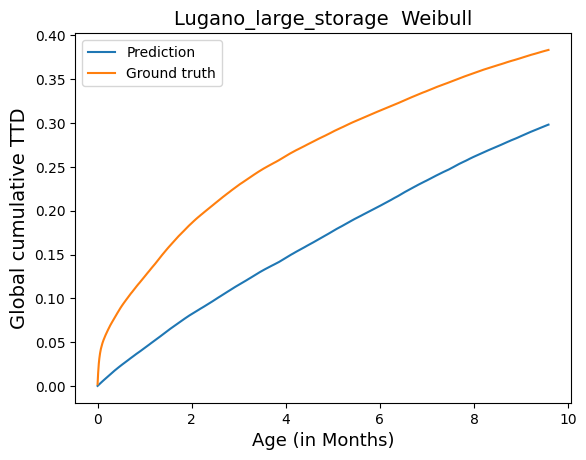

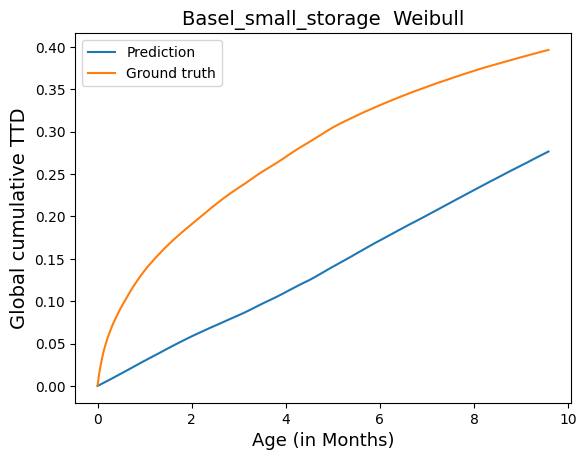

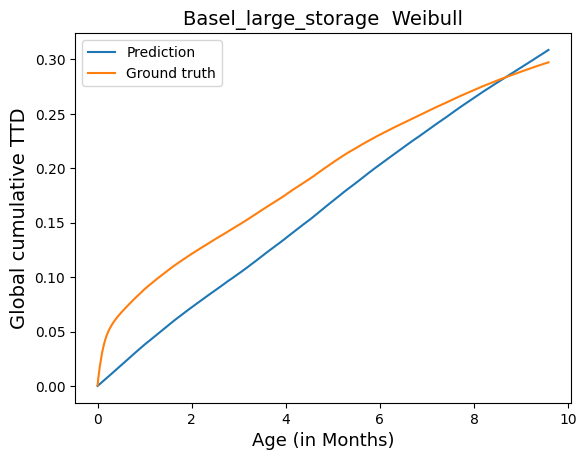

In [19]:
show_global_cum_ttd(results, algo2name=algo2name)

# 4. Survival functions

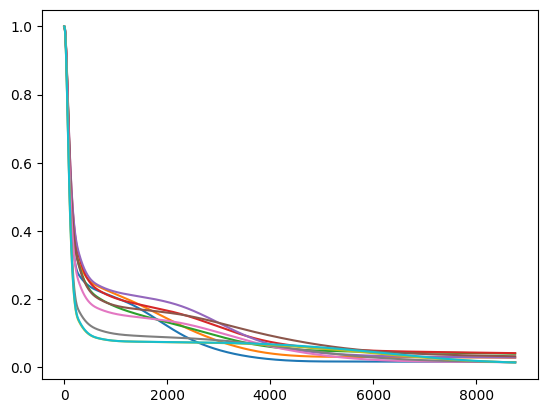

In [18]:
for i in range(10):
    plt.plot(results[sites[0]][algo]['w'][i*200,:24*365])

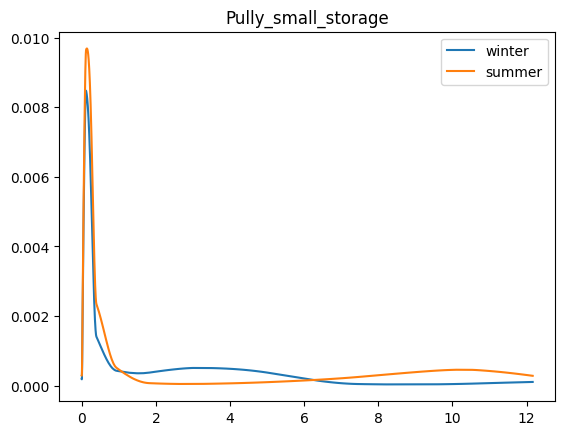

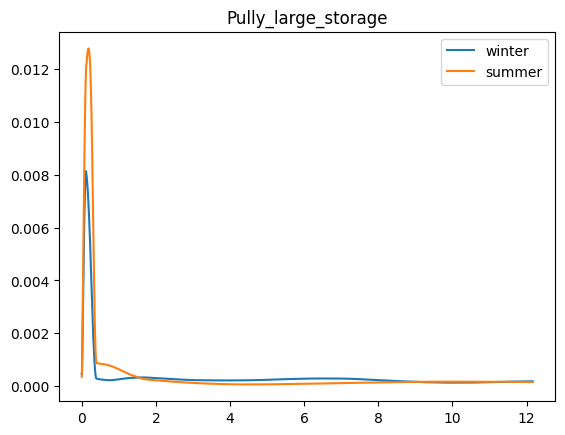

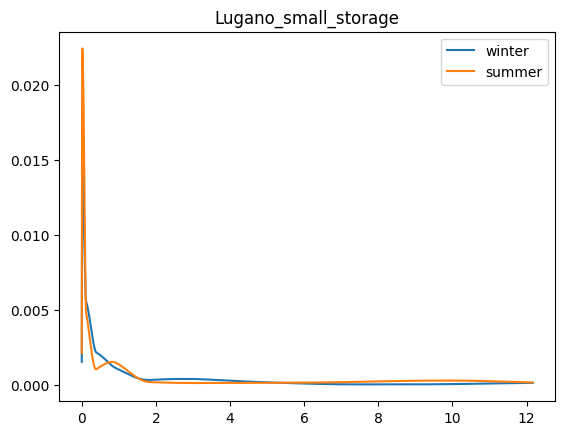

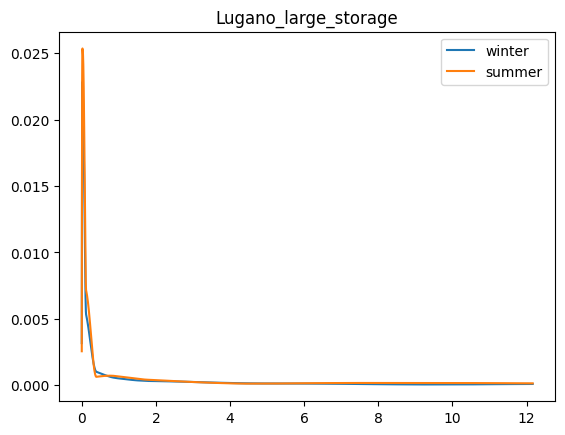

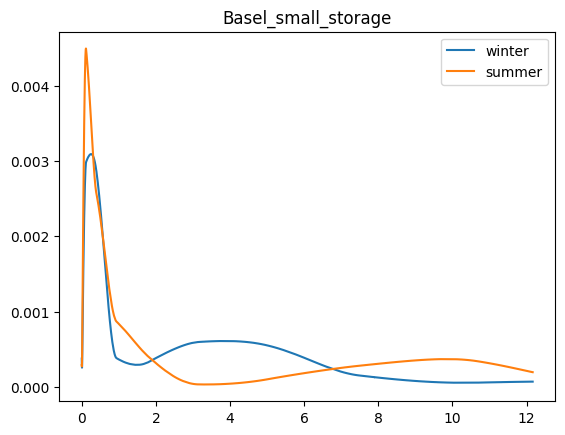

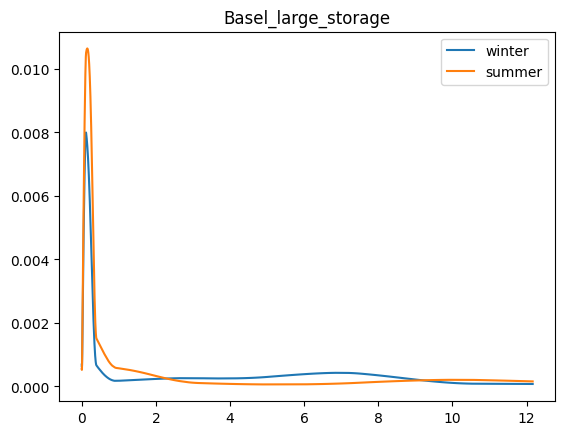

In [32]:
for site in sites:
    frac_year = results[site][algo]['timeyear_test']
    frac_year = [el-int(el) for el in frac_year]
    frac_year = np.array([min([1-el, el]) for el in frac_year])
    winter_idxs = np.where(frac_year<=(2*30/365))[0]
    summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
    plt.plot(np.arange(24*365-1)/(24*30), np.diff(-np.log(torch.mean(results[site][algo]['w'][winter_idxs,:24*365], dim=0))), label='winter')
    plt.plot(np.arange(24*365-1)/(24*30), np.diff(-np.log(torch.mean(results[site][algo]['w'][summer_idxs,:24*365], dim=0))), label='summer')
    plt.legend()
    plt.title(site)
    plt.show()

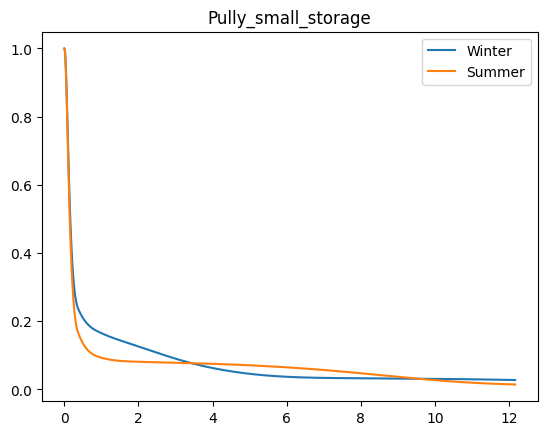

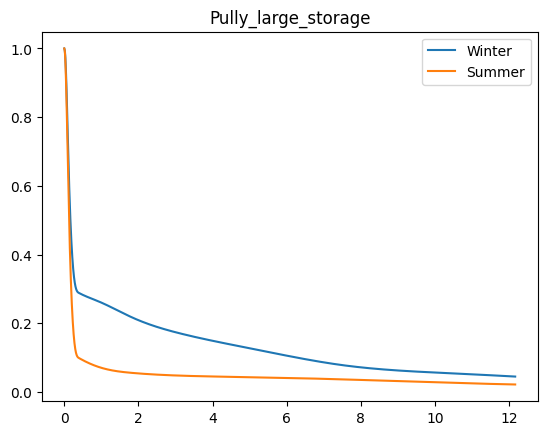

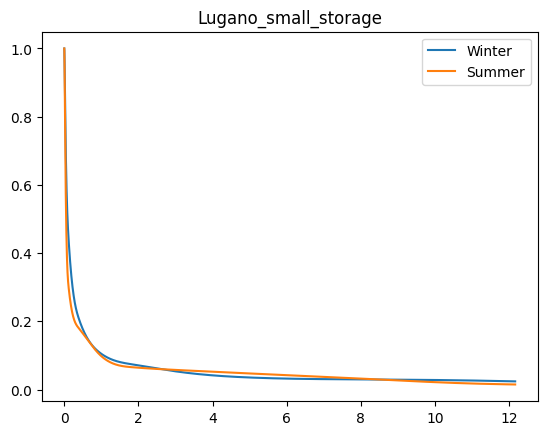

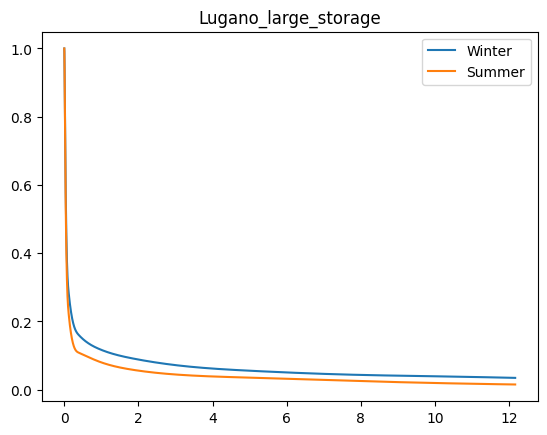

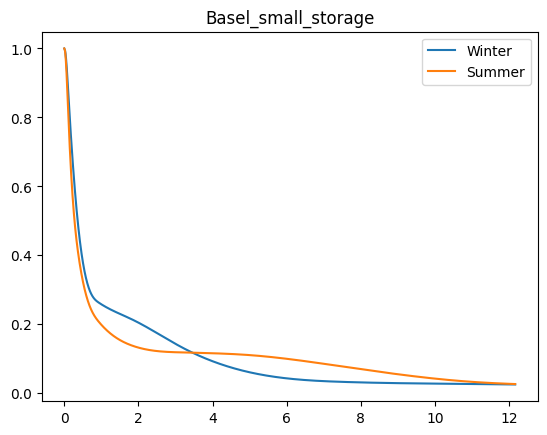

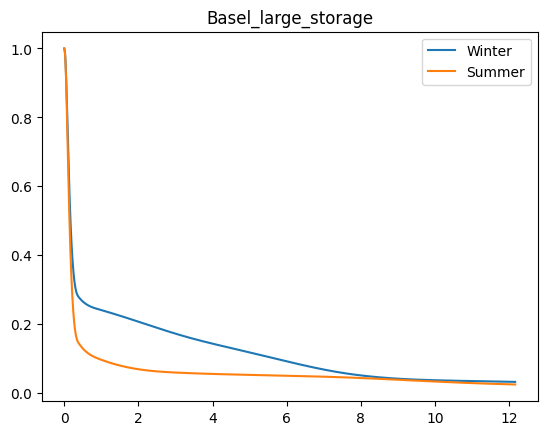

In [33]:
for site in sites:
    frac_year = results[site][algo]['timeyear_test']
    frac_year = [el-int(el) for el in frac_year]
    frac_year = np.array([min([1-el, el]) for el in frac_year])
    winter_idxs = np.where(frac_year<=(2*30/365))[0]
    summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
    plt.plot(np.arange(24*365)/(24*30), torch.mean(results[site][algo]['w'][winter_idxs,:24*365], dim=0), label='Winter')
    plt.plot(np.arange(24*365)/(24*30), torch.mean(results[site][algo]['w'][summer_idxs,:24*365], dim=0), label='Summer')
    plt.legend()
    plt.title(site)
    plt.show()

## The code below allows to visualize time specific TTDs for Pully small storage

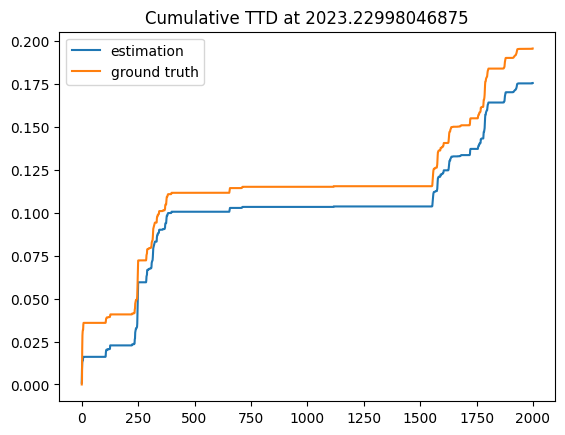

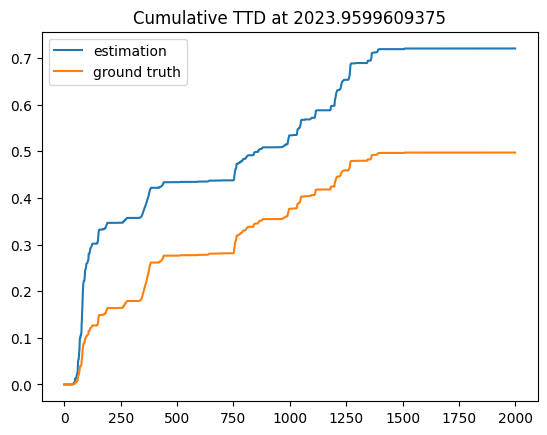

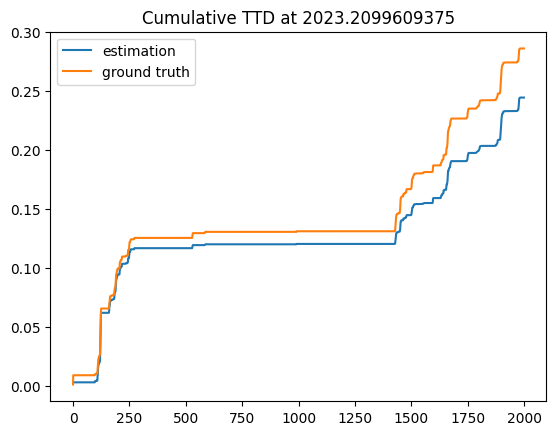

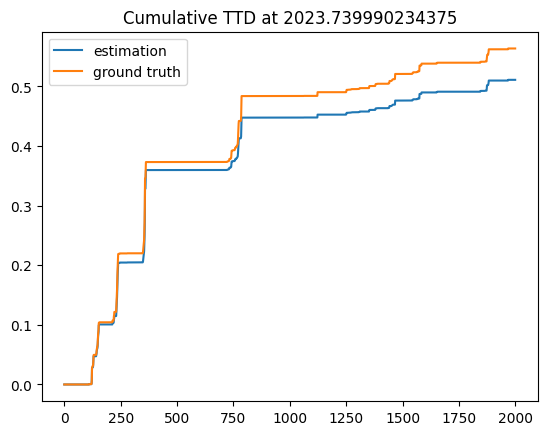

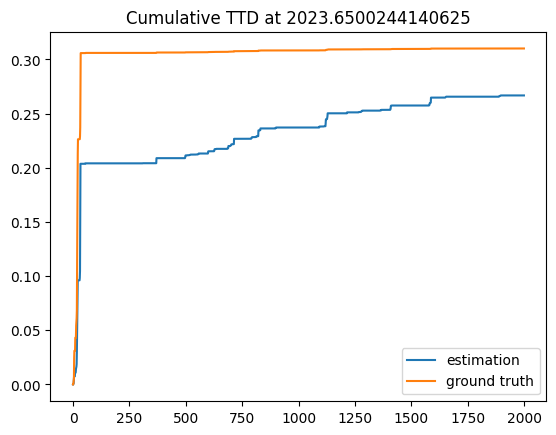

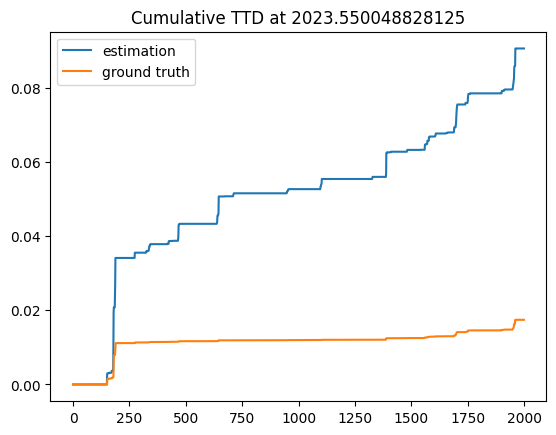

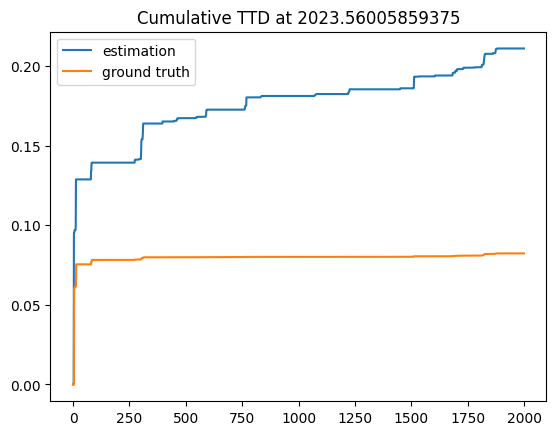

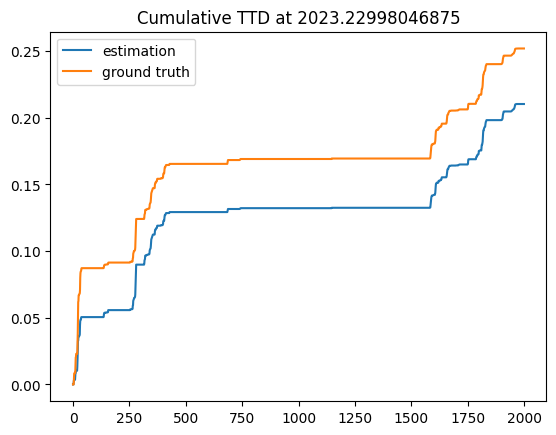

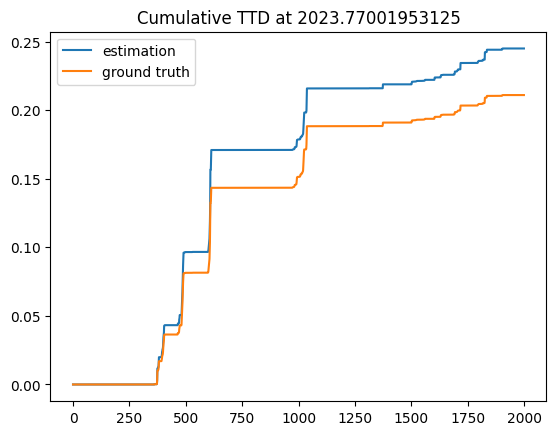

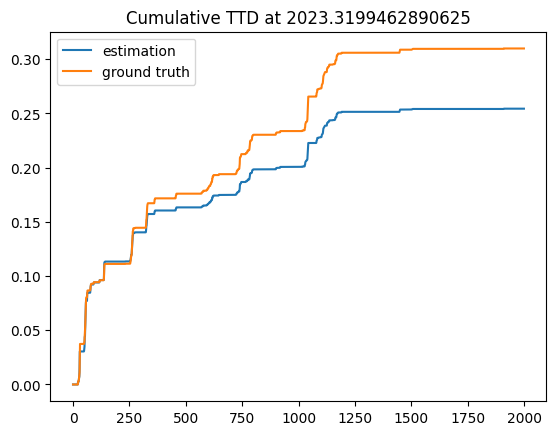

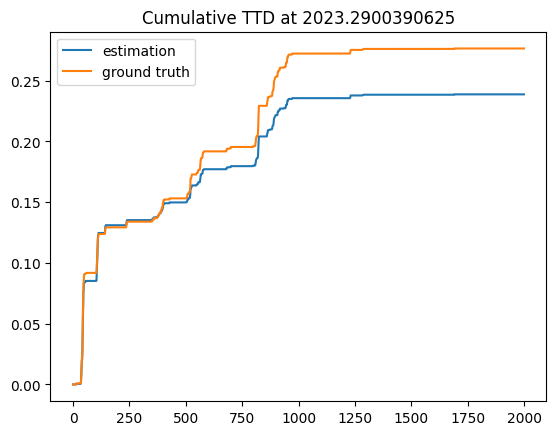

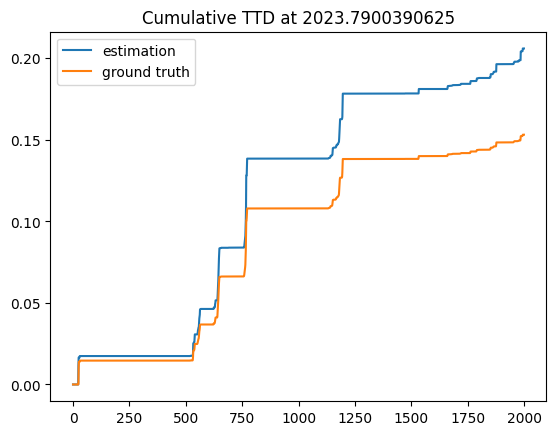

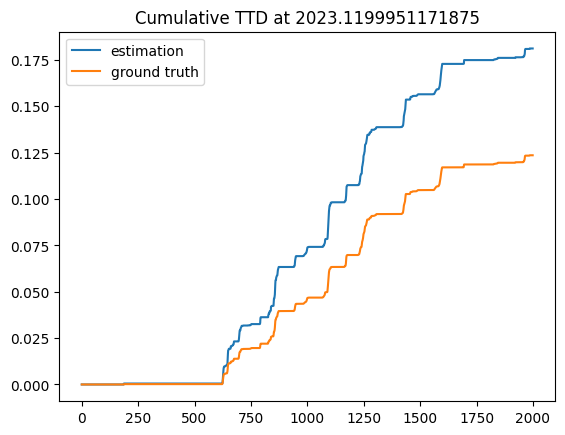

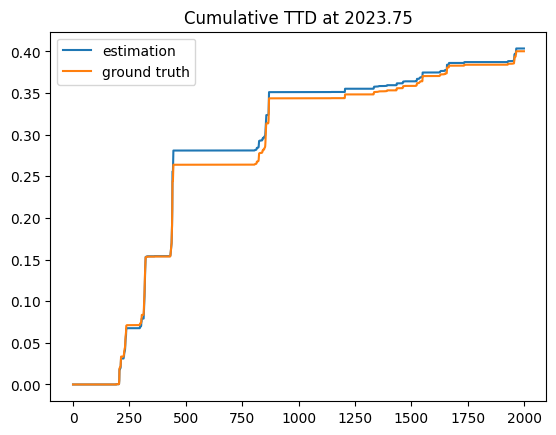

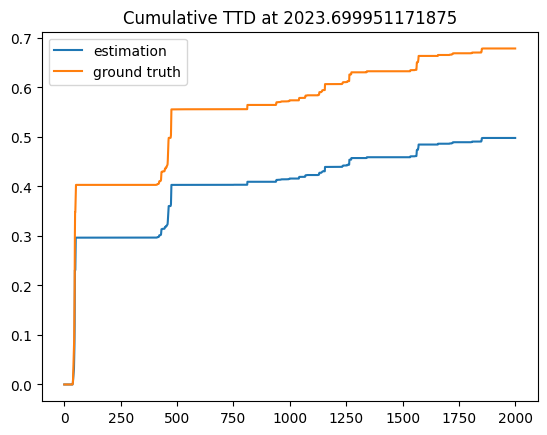

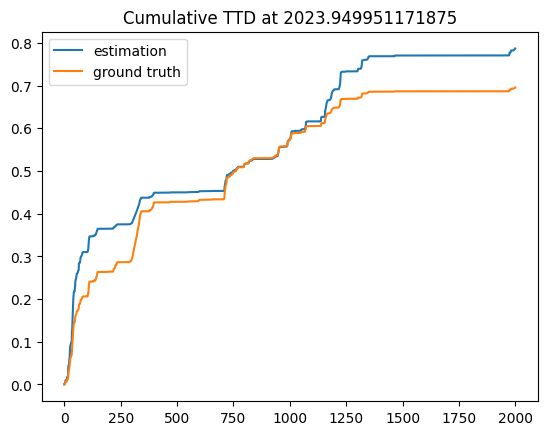

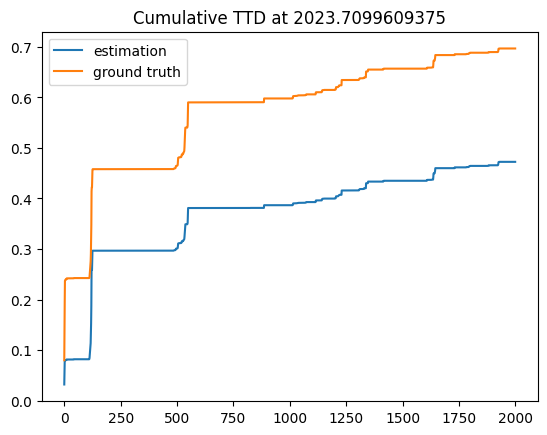

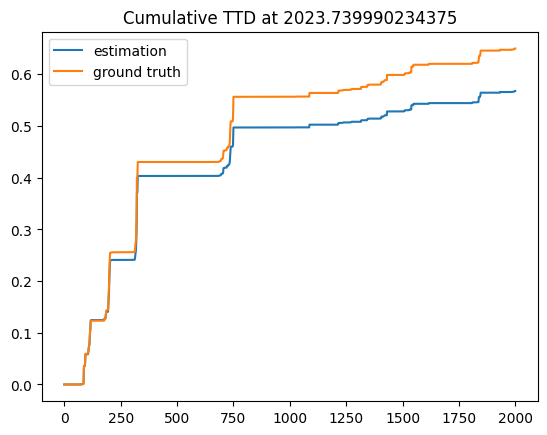

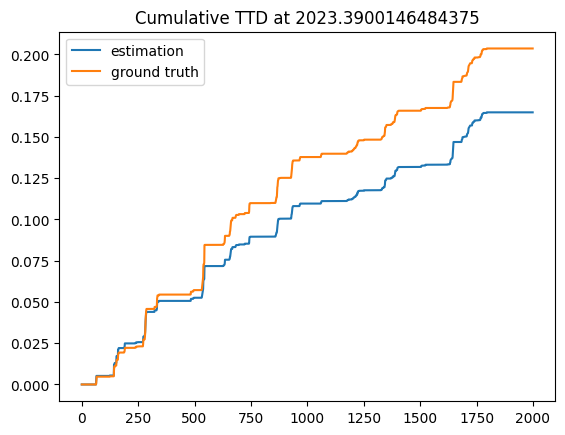

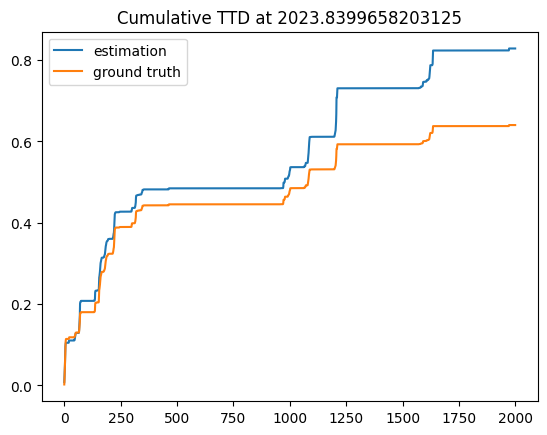

In [44]:
for i in range(20,40):
    n = results[sites[0]][algo]['PQhat'].shape[1]
    import random
    t = random.randint(0, n)
    plt.plot(results[sites[0]][algo]['PQhat'][:2000,t], label='estimation')
    plt.plot(results[sites[0]][algo]['PQtrue'][t,:2000], label='ground truth')
    plt.title('Cumulative TTD at {0}'.format(np.round(results[sites[0]][algo]['timeyear_test'][t], 2)))
    plt.legend()
    plt.show()